<a href="https://colab.research.google.com/github/MacKumachin/Clifford-FBSM-SignalControl/blob/main/Clifford_FBSM_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Clifford Signal Field Simulation via FBSM
This notebook performs optimal control of a Clifford-valued signal field using the Forward–Backward Sweep Method (FBSM), visualizes its rank, entropy, and curvature over time.

In [1]:
'.config', '__pycache__', '.ipynb_checkpoints',
'CliffordTimeSeriesPlots.py', 'FBSM_optimizer.py',
'CliffordDynamics.py', 'CliffordTensor.py',
'main_clifford_fbsbm_driver.py', 'sample_data'


('main_clifford_fbsbm_driver.py', 'sample_data')

In [3]:
# === Upload 4 arrays (any names) -> value-based auto classification -> ECDF PDFs ===
import os, numpy as np, matplotlib; matplotlib.use("Agg")
import matplotlib.pyplot as plt
from google.colab import files

OUTDIR="analysis_out"; os.makedirs(OUTDIR, exist_ok=True)

def load_any(p):
    ext = os.path.splitext(p)[1].lower()
    if ext==".npy": return np.asarray(np.load(p, allow_pickle=False)).ravel()
    if ext==".npz":
        z=np.load(p, allow_pickle=True)
        # 最大の配列を採用
        best=None; n=-1
        for k in z.files:
            a=np.asarray(z[k]).ravel()
            if a.size>n: best=a; n=a.size
        return best
    if ext in [".txt",".csv"]:
        try: a=np.loadtxt(p, delimiter="," if ext==".csv" else None)
        except: a=np.genfromtxt(p, delimiter="," if ext==".csv" else None)
        return np.asarray(a).ravel()
    raise ValueError("Unsupported format:"+p)

def ecdf_pdf(x,y,xlabel,out_pdf):
    x=np.clip(np.asarray(x).ravel(),0,None)
    y=np.clip(np.asarray(y).ravel(),0,None)
    sx,px=np.sort(x),np.linspace(0,1,len(x),endpoint=True)
    sy,py=np.sort(y),np.linspace(0,1,len(y),endpoint=True)
    plt.figure(figsize=(6,4.5))
    plt.step(sx,px,where="post",label="Baseline")
    plt.step(sy,py,where="post",label="Control")
    plt.xlabel(xlabel); plt.ylabel("ECDF"); plt.legend()
    plt.tight_layout(); plt.savefig(out_pdf,bbox_inches="tight"); plt.close()

print("4つの配列ファイルを選択（length×2, curvature×2）。拡張子は .npy/.npz/.txt/.csv いずれでもOK。")
up = files.upload()
if len(up)<4:
    raise RuntimeError("4ファイルアップロードしてください。")

# 値域で length/curvature を自動判別、meanで base/ctrl を推定（lengthはmean大→control, curvatureはmean小→control）
arrs=[]
for fn in up.keys():
    a=load_any(fn); a=a[np.isfinite(a)]
    arrs.append((fn,a, float(np.mean(a)), float(np.percentile(a,95)), float(np.max(a))))
arrs.sort(key=lambda t:t[2])  # だいたい小さい=curvature, 大きい=length

# 下位2つ→curvature, 上位2つ→length
curA, curB = arrs[0], arrs[1]
lenA, lenB = arrs[2], arrs[3]

# base/ctrl 推定
cur_base, cur_ctrl = (curB, curA) if curA[2] <= curB[2] else (curA, curB)   # mean小さい方=control
len_base, len_ctrl = (lenA, lenB) if lenA[2] <= lenB[2] else (lenB, lenA)   # mean大きい方=control

print("\n自動割当（要確認）:")
print("  Length  baseline:", len_base[0], " control:", len_ctrl[0])
print("  Curv.   baseline:", cur_base[0], " control:", cur_ctrl[0])

# 生成
len_pdf=os.path.join(OUTDIR,"fig_ecdf_length.pdf")
cur_pdf=os.path.join(OUTDIR,"fig_ecdf_curvature.pdf")
ecdf_pdf(len_base[1], len_ctrl[1], "Streamline length (mm)", len_pdf)
ecdf_pdf(cur_base[1], cur_ctrl[1], "Streamline curvature (1/mm)", cur_pdf)

with open(os.path.join(OUTDIR,"fig_snippet_len_curv.tex"),"w") as f:
    f.write(r"""\begin{figure}[t]
  \centering
  \includegraphics[width=0.48\linewidth]{fig_ecdf_length.pdf}\hfill
  \includegraphics[width=0.48\linewidth]{fig_ecdf_curvature.pdf}
  \caption{Distributional comparison (ECDF) of streamline length and curvature: baseline vs.\ delayed control.}
  \label{fig:ecdf_len_curv}
\end{figure}
""")

print("\nSaved:")
print(" -", len_pdf)
print(" -", cur_pdf)
print(" -", os.path.join(OUTDIR,"fig_snippet_len_curv.tex"))


4つの配列ファイルを選択（length×2, curvature×2）。拡張子は .npy/.npz/.txt/.csv いずれでもOK。


RuntimeError: 4ファイルアップロードしてください。

In [4]:
# 例: Driveをマウント
from google.colab import drive
drive.mount('/content/drive')

# ==== 手動マッピング ====
LENGTH_BASE = "/content/drive/MyDrive/DTI/len_A.npy"
LENGTH_CTRL = "/content/drive/MyDrive/DTI/len_B.npy"
CURV_BASE   = "/content/drive/MyDrive/DTI/curv_A.npy"
CURV_CTRL   = "/content/drive/MyDrive/DTI/curv_B.npy"

# 以下は固定
import os, numpy as np, matplotlib; matplotlib.use("Agg")
import matplotlib.pyplot as plt
os.makedirs("analysis_out", exist_ok=True)

def _load(p):
    import numpy as np, os
    ext=os.path.splitext(p)[1].lower()
    if ext==".npy": return np.load(p,allow_pickle=False).ravel()
    if ext==".npz":
        z=np.load(p,allow_pickle=True)
        return np.asarray(z[z.files[0]]).ravel()
    raise ValueError("Use npy/npz here")

def _ecdf(x,y,xlabel,pdf):
    x=np.clip(x,0,None); y=np.clip(y,0,None)
    sx,px=np.sort(x),np.linspace(0,1,len(x),endpoint=True)
    sy,py=np.sort(y),np.linspace(0,1,len(y),endpoint=True)
    plt.figure(figsize=(6,4.5))
    plt.step(sx,px,where="post",label="Baseline")
    plt.step(sy,py,where="post",label="Control")
    plt.xlabel(xlabel); plt.ylabel("ECDF"); plt.legend()
    plt.tight_layout(); plt.savefig(pdf,bbox_inches="tight"); plt.close()

lb=_load(LENGTH_BASE); lc=_load(LENGTH_CTRL)
cb=_load(CURV_BASE);   cc=_load(CURV_CTRL)

_ecdf(lb, lc, "Streamline length (mm)", "analysis_out/fig_ecdf_length.pdf")
_ecdf(cb, cc, "Streamline curvature (1/mm)", "analysis_out/fig_ecdf_curvature.pdf")
print("Saved PDFs in analysis_out/")


Mounted at /content/drive


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/DTI/len_A.npy'

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

ROOT = '/content/drive/MyDrive'  # 必要なら '/content/drive/MyDrive/DTI' などに変更
import os, fnmatch

hits = []
for root, dirs, files in os.walk(ROOT):
    depth = root.count(os.sep) - ROOT.count(os.sep)
    if depth > 5:  # 深すぎる探索はスキップ
        continue
    for pat in ('*.npy','*.npz','*.txt','*.csv'):
        for name in fnmatch.filter(files, pat):
            path = os.path.join(root, name)
            try:
                size = os.path.getsize(path)
                hits.append((size, path))
            except Exception:
                pass

hits.sort(reverse=True)  # 大きい順に表示
for i, (size, path) in enumerate(hits[:200]):
    print(f'[{i:03d}] {size/1e6:6.1f} MB  {path}')

print("\n→ 上の一覧から、length の baseline/control と curvature の baseline/control に相当する 4つの [ID] を控えてください。")


Mounted at /content/drive
[000]    0.0 MB  /content/drive/MyDrive/ColabFiles/field_final.npy
[001]    0.0 MB  /content/drive/MyDrive/ColabFiles/control_u_final.npy
[002]    0.0 MB  /content/drive/MyDrive/ColabFiles/f_final.npy
[003]    0.0 MB  /content/drive/MyDrive/ColabFiles/curvature_final.npy
[004]    0.0 MB  /content/drive/MyDrive/ColabFiles/rank_series.npy
[005]    0.0 MB  /content/drive/MyDrive/ColabFiles/rank_over_time.npy
[006]    0.0 MB  /content/drive/MyDrive/ColabFiles/curvature_over_time.npy

→ 上の一覧から、length の baseline/control と curvature の baseline/control に相当する 4つの [ID] を控えてください。


In [6]:
# === Curvature ECDF from curvature_over_time.npy (t=0 vs t=end) ===
import os, numpy as np, matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt

CURV_OVER = "/content/drive/MyDrive/ColabFiles/curvature_over_time.npy"
CURV_FINAL = "/content/drive/MyDrive/ColabFiles/curvature_final.npy"  # なくてもOK（検証用）

def _load(p):
    a = np.load(p, allow_pickle=True)
    return np.asarray(a)

def _ecdf(x, y, xlabel, pdf):
    x = np.clip(np.asarray(x).ravel(), 0, None)
    y = np.clip(np.asarray(y).ravel(), 0, None)
    sx, px = np.sort(x), np.linspace(0,1,len(x),endpoint=True)
    sy, py = np.sort(y), np.linspace(0,1,len(y),endpoint=True)
    plt.figure(figsize=(6,4.5))
    plt.step(sx, px, where="post", label="Baseline")
    plt.step(sy, py, where="post", label="Control")
    plt.xlabel(xlabel); plt.ylabel("ECDF"); plt.legend()
    plt.tight_layout(); plt.savefig(pdf, bbox_inches="tight"); plt.close()

C = _load(CURV_OVER)
# 形状の想定： (T, N) or (N, T) or (T,) のどれか
if C.ndim == 2:
    # T×N または N×T を自動判定（時間軸=短い方と仮定）
    t_axis = 0 if C.shape[0] <= C.shape[1] else 1
    curv_base = C[0, :] if t_axis == 0 else C[:, 0]
    curv_ctrl = C[-1, :] if t_axis == 0 else C[:, -1]
elif C.ndim == 1:
    # 時系列しか無い（N=1）場合は baseline が無いので final として扱う
    # その場合は curvature_final.npy を control として使い、baseline は別フォルダから用意してください
    raise RuntimeError("curvature_over_time.npy が 1次元（純時系列）で baseline 切り出し不可。baseline 配列が別に必要です。")
else:
    raise RuntimeError(f"Unsupported shape for {CURV_OVER}: {C.shape}")

os.makedirs("analysis_out", exist_ok=True)
_ecdf(curv_base, curv_ctrl, "Streamline curvature (1/mm)", "analysis_out/fig_ecdf_curvature.pdf")

with open("analysis_out/fig_snippet_len_curv.tex","w") as f:
    f.write(r"""\begin{figure}[t]
  \centering
  \includegraphics[width=0.48\linewidth]{fig_ecdf_length.pdf}\hfill
  \includegraphics[width=0.48\linewidth]{fig_ecdf_curvature.pdf}
  \caption{Distributional comparison (ECDF) of streamline length and curvature: baseline vs.\ delayed control.}
  \label{fig:ecdf_len_curv}
\end{figure}
""")
print("Saved -> analysis_out/fig_ecdf_curvature.pdf")


RuntimeError: curvature_over_time.npy が 1次元（純時系列）で baseline 切り出し不可。baseline 配列が別に必要です。

In [7]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, fnmatch
ROOT = '/content/drive/MyDrive'
hits = []
for root, dirs, files in os.walk(ROOT):
    for name in files:
        if fnmatch.fnmatch(name.lower(), 'curvature_final.npy'):
            path = os.path.join(root, name)
            hits.append(path)

if not hits:
    print("Drive内に curvature_final.npy が見つかりません。各実験出力フォルダに保存されているか確認してください。")
else:
    for i,p in enumerate(hits):
        print(f"[{i:02d}] {p}")

print("\n上の一覧から Baseline 用と Control 用に相当する2つの [ID] を決めて、次のセルに入れてください。")


Mounted at /content/drive
[00] /content/drive/MyDrive/ColabFiles/curvature_final.npy

上の一覧から Baseline 用と Control 用に相当する2つの [ID] を決めて、次のセルに入れてください。


In [8]:
# Drive内の curvature_final.npy を全部列挙
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, fnmatch
ROOT = '/content/drive/MyDrive'
hits = []
for root, dirs, files in os.walk(ROOT):
    for name in files:
        if fnmatch.fnmatch(name.lower(), 'curvature_final.npy'):
            hits.append(os.path.join(root, name))
for i,p in enumerate(hits):
    print(f"[{i:02d}] {p}")


Mounted at /content/drive
[00] /content/drive/MyDrive/ColabFiles/curvature_final.npy


In [9]:
# Drive内にある curvature_final.npy を全部列挙（baseline用が既にあるかチェック）
from google.colab import drive; drive.mount('/content/drive', force_remount=True)
import os, fnmatch
ROOT = '/content/drive/MyDrive'
hits = []
for root, dirs, files in os.walk(ROOT):
    for name in files:
        if fnmatch.fnmatch(name.lower(), 'curvature_final.npy'):
            hits.append(os.path.join(root, name))
for i,p in enumerate(hits):
    print(f"[{i:02d}] {p}")

# 例） baseline が [0]、control が [1] のように2本あるなら、次のステップ2へ


Mounted at /content/drive
[00] /content/drive/MyDrive/ColabFiles/curvature_final.npy


In [10]:
# === Curvature ECDF（baseline vs control） ===
import numpy as np, os, matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt

BASE = "/content/drive/MyDrive/ColabFiles/curvature_final_baseline.npy"  # 1-Bで作ったもの
CTRL = "/content/drive/MyDrive/ColabFiles/curvature_final.npy"           # 既存のもの

curv_base = np.load(BASE, allow_pickle=False).ravel()
curv_ctrl = np.load(CTRL, allow_pickle=False).ravel()

def ecdf_pdf(x, y, xlabel, out_pdf):
    x = np.clip(np.asarray(x).ravel(), 0, None)
    y = np.clip(np.asarray(y).ravel(), 0, None)
    sx, px = np.sort(x), np.linspace(0,1,len(x),endpoint=True)
    sy, py = np.sort(y), np.linspace(0,1,len(y),endpoint=True)
    plt.figure(figsize=(6,4.5))
    plt.step(sx, px, where="post", label="Baseline")
    plt.step(sy, py, where="post", label="Control")
    plt.xlabel(xlabel); plt.ylabel("ECDF"); plt.legend()
    plt.tight_layout(); plt.savefig(out_pdf, bbox_inches="tight"); plt.close()

os.makedirs("analysis_out", exist_ok=True)
ecdf_pdf(curv_base, curv_ctrl, "Streamline curvature (1/mm)", "analysis_out/fig_ecdf_curvature.pdf")

with open("analysis_out/fig_snippet_len_curv.tex","w") as f:
    f.write(r"""\begin{figure}[t]
  \centering
  \includegraphics[width=0.48\linewidth]{fig_ecdf_length.pdf}\hfill
  \includegraphics[width=0.48\linewidth]{fig_ecdf_curvature.pdf}
  \caption{Distributional comparison (ECDF) of streamline length and curvature: baseline vs.\ delayed control.}
  \label{fig:ecdf_len_curv}
\end{figure}
""")
print("Saved -> analysis_out/fig_ecdf_curvature.pdf（LaTeXスニペットも出力）")


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/ColabFiles/curvature_final_baseline.npy'

In [14]:
# === create baseline curvature_final_baseline.npy (u=0 run) ===
import numpy as np, os, sys
from google.colab import drive; drive.mount('/content/drive', force_remount=True)
sys.path.append("/content")  # あなたのモジュールの場所

# ★ control と同じ条件にそろえる（Nx, Ny, T, dt, f0）
Nx, Ny = 64, 64      # ←あなたの値に
T, dt  = 20, 1.0     # ←あなたの値に
np.random.seed(0)    # control と同じ乱数種を使う or control 実行時に保存した f0 を読み込む
f0 = np.random.rand(Nx, Ny)  # もし保存済みf0があるなら np.load("そのパス") に置換

# ★ あなたの実装に合わせて import
from CliffordTensor import create_spin_connection_field, compute_clifford_curvature
from CliffordDynamics import solve_forward_geometric   # ←名称が違うならあなたの forward 関数に

A = create_spin_connection_field(Nx, Ny)
u_zero = np.zeros((Nx, Ny))

traj = solve_forward_geometric(f0, A, u_zero, T, dt)   # 前進のみ（u=0）
curv_base = compute_clifford_curvature(traj[-1])       # 最終時刻の曲率マップ

SAVE_TO = "/content/drive/MyDrive/ColabFiles/curvature_final_baseline.npy"
np.save(SAVE_TO, curv_base)
print("Saved:", SAVE_TO)


Mounted at /content/drive


TypeError: create_spin_connection_field() missing 1 required positional argument: 'Nt'

In [15]:
# === u=0 baseline を作って curvature_final_baseline.npy を保存（引数パターンを自動調整） ===
import os, sys, numpy as np
from google.colab import drive; drive.mount('/content/drive', force_remount=True)
sys.path.append("/content")  # あなたの .py がある場所（必要に応じて追加）

# ★ control と同じ条件にそろえる
Nx, Ny = 64, 64
T, dt  = 20, 1.0
Nt = int(round(T/dt)) + 1   # 例: t=0 を含める想定。実装に合わせて +/-1 調整可

# ★ 初期場：control と同一に（保存済み f0 があればそれを読む）
np.random.seed(0)
f0 = np.random.rand(Nx, Ny)

# あなたの実装に合わせて import
from CliffordTensor   import create_spin_connection_field, compute_clifford_curvature
from CliffordDynamics import solve_forward_geometric

# A を作成（2引数 or 3引数の両方に対応）
try:
    A = create_spin_connection_field(Nx, Ny, Nt)
except TypeError:
    A = create_spin_connection_field(Nx, Ny)

# u=0（時間不変 or 時間変化の両方を試す）
u2 = np.zeros((Nx, Ny))        # 2D（時間不変）
u3 = np.zeros((Nt, Nx, Ny))    # 3D（時


Mounted at /content/drive


In [17]:
import numpy as np, os, matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt

BASE = "/content/drive/MyDrive/ColabFiles/curvature_final_baseline.npy"
CTRL = "/content/drive/MyDrive/ColabFiles/curvature_final.npy"

curv_base = np.load(BASE, allow_pickle=False).ravel()
curv_ctrl = np.load(CTRL, allow_pickle=False).ravel()

def ecdf_pdf(x, y, xlabel, out_pdf):
    x = np.clip(np.asarray(x).ravel(), 0, None)
    y = np.clip(np.asarray(y).ravel(), 0, None)
    sx, px = np.sort(x), np.linspace(0,1,len(x),endpoint=True)
    sy, py = np.sort(y), np.linspace(0,1,len(y),endpoint=True)
    plt.figure(figsize=(6,4.5))
    plt.step(sx, px, where="post", label="Baseline")
    plt.step(sy, py, where="post", label="Control")
    plt.xlabel(xlabel); plt.ylabel("ECDF"); plt.legend()
    plt.tight_layout(); plt.savefig(out_pdf, bbox_inches="tight"); plt.close()

os.makedirs("analysis_out", exist_ok=True)
ecdf_pdf(curv_base, curv_ctrl, "Streamline curvature (1/mm)", "analysis_out/fig_ecdf_curvature.pdf")
print("📄 Saved -> analysis_out/fig_ecdf_curvature.pdf")


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/ColabFiles/curvature_final_baseline.npy'

In [18]:
# === Make baseline if missing, then output curvature ECDF (baseline vs control) ===
import os, sys, numpy as np, matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
from google.colab import drive; drive.mount('/content/drive', force_remount=True)

# ---- paths ----
BASE_P = "/content/drive/MyDrive/ColabFiles/curvature_final_baseline.npy"  # これを作る
CTRL_P = "/content/drive/MyDrive/ColabFiles/curvature_final.npy"          # 既存（control）

# ---- forward settings (control と同じに！) ----
Nx, Ny = 64, 64
T, dt  = 20, 1.0
Nt     = int(round(T/dt)) + 1  # 実装流儀に合わせて±1 調整可

# ---- import your modules ----
sys.path.append("/content")  # あなたの .py が見える場所
from CliffordTensor   import create_spin_connection_field, compute_clifford_curvature
from CliffordDynamics import solve_forward_geometric

# ---- create baseline if not exists ----
if not os.path.exists(BASE_P):
    print("Baseline file not found. Creating u=0 baseline…")
    # 初期場 f0：control 実験と同じものを使うのが理想（保存済みがあれば読み込んで置換してください）
    np.random.seed(0)
    f0 = np.random.rand(Nx, Ny)

    # A: 2引数/3引数どちらでも対応
    try:
        A = create_spin_connection_field(Nx, Ny, Nt)
    except TypeError:
        A = create_spin_connection_field(Nx, Ny)

    # 前進：u=0（2D or 3D どちらのシグネチャでも試す）
    try:
        traj = solve_forward_geometric(f0, A, np.zeros((Nx, Ny)), T, dt)
    except TypeError:
        try:
            traj = solve_forward_geometric(f0, A, np.zeros((Nt, Nx, Ny)), T, dt)
        except TypeError:
            traj = solve_forward_geometric(f0, A, np.zeros((Nt, Nx, Ny)),


SyntaxError: incomplete input (ipython-input-2527656436.py, line 41)

In [19]:
# === Baseline を自動生成（必要なら）→ 曲率ECDFを出力 ===
import os, sys, numpy as np, matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
from google.colab import drive; drive.mount('/content/drive', force_remount=True)

# ---- 設定（control と同じに！）----
Nx, Ny = 64, 64
T, dt  = 20, 1.0
Nt     = int(round(T/dt)) + 1   # 実装流儀に合わせて±1は調整可

BASE_P = "/content/drive/MyDrive/ColabFiles/curvature_final_baseline.npy"  # 作る
CTRL_P = "/content/drive/MyDrive/ColabFiles/curvature_final.npy"          # 既存

# ---- モジュールの読み込み（あなたの .py が見える場所を通す）----
sys.path.append("/content")
from CliffordTensor   import create_spin_connection_field, compute_clifford_curvature
from CliffordDynamics import solve_forward_geometric

# ---- Baseline を作る（なければ）----
if not os.path.exists(BASE_P):
    print("Baseline not found. Creating u=0 baseline ...")

    # f0：理想は control と同一の初期場（保存済みがあれば np.load で置換）
    np.random.seed(0)
    f0 = np.random.rand(Nx, Ny)

    # A: 3引数か2引数かを自動で切替
    try:
        A = create_spin_connection_field(Nx, Ny, Nt)
    except TypeError:
        A = create_spin_connection_field(Nx, Ny)

    # u=0 の候補（2D/3Dの両方）
    u2 = np.zeros((Nx, Ny))
    u3 = np.zeros((Nt, Nx, Ny))

    # solve_forward_geometric の呼び方を順に試す
    traj = None
    for candidate in (
        lambda: solve_forward_geometric(f0, A, u2, T, dt),
        lambda: solve_forward_geometric(f0, A, u3, T, dt),
        lambda: solve_forward_geometric(f0, A, u3, Nt, dt),
        lambda: solve_forward_geometric(f0, A, u2, Nt, dt),
    ):
        try:
            traj = candidate()
            break
        except TypeError:
            pass
    if traj is None:
        raise RuntimeError("solve_forward_geometric のシグネチャが想定外です。関数定義を教えてください。")

    curv_base = compute_clifford_curvature(traj[-1])
    os.makedirs(os.path.dirname(BASE_P), exist_ok=True)
    np.save(BASE_P, curv_base)
    print("✅ Saved baseline:", BASE_P)
else:
    print("Baseline exists:", BASE_P)

# ---- control があるか確認 ----
if not os.path.exists(CTRL_P):
    raise FileNotFoundError(f"Control curvature missing: {CTRL_P}")

# ---- 読み込み＆ログ ----
curv_base = np.load(BASE_P, allow_pickle=False).ravel()
curv_ctrl = np.load(CTRL_P, allow_pickle=False).ravel()
print("baseline:", curv_base.shape, "mean=", float(curv_base.mean()))
print("control :", curv_ctrl.shape, "mean=", float(curv_ctrl.mean()))

# ---- ECDF 図を保存 ----
def ecdf_pdf(x, y, xlabel, out_pdf):
    x = np.clip(np.asarray(x).ravel(), 0, None)
    y = np.clip(np.asarray(y).ravel(), 0, None)
    sx, px = np.sort(x), np.linspace(0,1,len(x),endpoint=True)
    sy, py = np.sort(y), np.linspace(0,1,len(y),endpoint=True)
    plt.figure(figsize=(6,4.5))
    plt.step(sx, px, where="post", label="Baseline")
    plt.step(sy, py, where="post", label="Control")
    plt.xlabel(xlabel); plt.ylabel("ECDF"); plt.legend()
    plt.tight_layout(); plt.savefig(out_pdf, bbox_inches="tight"); plt.close()

os.makedirs("analysis_out", exist_ok=True)
ecdf_pdf(curv_base, curv_ctrl, "Streamline curvature (1/mm)", "analysis_out/fig_ecdf_curvature.pdf")

with open("analysis_out/fig_snippet_len_curv.tex","w") as f:
    f.write(r"""\begin{figure}[t]
  \centering
  \includegraphics[width=0.48\linewidth]{fig_ecdf_length.pdf}\hfill
  \includegraphics[width=0.48\linewidth]{fig_ecdf_curvature.pdf}
  \caption{Distributional comparison (ECDF) of streamline length and curvature: baseline vs.\ delayed control.}
  \label{fig:ecdf_len_curv}
\end{figure}
""")
print("📄 Saved -> analysis_out/fig_ecdf_curvature.pdf（LaTeXスニペットも出力）")


Mounted at /content/drive
Baseline not found. Creating u=0 baseline ...


RuntimeError: solve_forward_geometric のシグネチャが想定外です。関数定義を教えてください。

In [20]:
# === Auto-detect forward solver -> make baseline if needed -> output curvature ECDF ===
import os, sys, inspect, numpy as np, matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
from google.colab import drive; drive.mount('/content/drive', force_remount=True)

# -------- settings (control と同じに揃える) --------
Nx, Ny = 64, 64
T, dt  = 20, 1.0
Nt     = int(round(T/dt)) + 1  # 実装により ±1 の調整あり
SEED   = 0                     # control 実験と同じならその種 or f0.npy を読み込む

BASE_P = "/content/drive/MyDrive/ColabFiles/curvature_final_baseline.npy"   # これを作る
CTRL_P = "/content/drive/MyDrive/ColabFiles/curvature_final.npy"           # 既存（control 側）

# 既存 baseline があればスキップ
need_make = not os.path.exists(BASE_P)

# -------- import your local modules --------
sys.path.append("/content")  # あなたの .py が見える場所
mods = []
for name in ("CliffordDynamics", "forward"):
    try:
        mods.append(__import__(name))
        print(f"✅ imported module: {name}")
    except Exception as e:
        print(f"⚠️ module not found or failed: {name} ({e})")

# -------- helper: curvature + ECDF --------
from CliffordTensor import compute_clifford_curvature
def ecdf_pdf(x, y, xlabel, out_pdf):
    x = np.clip(np.asarray(x).ravel(), 0, None)
    y = np.clip(np.asarray(y).ravel(), 0, None)
    sx, px = np.sort(x), np.linspace(0,1,len(x),endpoint=True)
    sy, py = np.sort(y), np.linspace(0,1,len(y),endpoint=True)
    plt.figure(figsize=(6,4.5))
    plt.step(sx, px, where="post", label="Baseline")
    plt.step(sy, py, where="post", label="Control")
    plt.xlabel(xlabel); plt.ylabel("ECDF"); plt.legend()
    plt.tight_layout(); plt.savefig(out_pdf, bbox_inches="tight"); plt.close()

# -------- forward candidates: auto-discover --------
candidates = []
for m in mods:
    for fname, fn in inspect.getmembers(m, inspect.isfunction):
        low = fname.lower()
        if ("forward" in low or "simulate" in low or "solve" in low) and ("back" not in low):
            sig = str(inspect.signature(fn))
            candidates.append((m.__name__, fname, fn, sig))
            print(f"🔎 candidate: {m.__name__}.{fname}{sig}")

if not candidates and need_make:
    raise RuntimeError("前進ソルバ関数が見つかりませんでした。modules: " + ", ".join([m.__name__ for m in mods]))

# -------- try to make baseline if needed --------
if need_make:
    # 初期場 f0：control と同一が理想。保存済み f0 があれば np.load で差し替えてください。
    np.random.seed(SEED)
    f0 = np.random.rand(Nx, Ny)

    # A（スピン接続フィールド）: 2引数 or 3引数の両対応
    from CliffordTensor import create_spin_connection_field
    try:
        A = create_spin_connection_field(Nx, Ny, Nt)
    except TypeError:
        A = create_spin_connection_field(Nx, Ny)

    u2 = np.zeros((Nx, Ny))        # 時間不変
    u3 = np.zeros((Nt, Nx, Ny))    # 時間変化

    tried = []
    traj = None
    for mod_name, fname, fn, sig in candidates:
        # 試す呼び方の組み合わせ
        call_patterns = [
            lambda: fn(f0, A, u2, T,  dt),
            lambda: fn(f0, A, u3, T,  dt),
            lambda: fn(f0, A, u3, Nt, dt),
            lambda: fn(f0, A, u2, Nt, dt),
            # 引数名がある場合のキーワード呼び
            lambda: fn(f0=f0, A=A, u=u2, T=T, dt=dt),
            lambda: fn(f0=f0, A=A, u=u3, T=T, dt=dt),
            lambda: fn(f0=f0, A=A, u=u3, Nt=Nt, dt=dt),
            lambda: fn(f0=f0, A=A, u=u2, Nt=Nt, dt=dt),
        ]
        for caller in call_patterns:
            try:
                traj = caller()
                print(f"✅ baseline forward succeeded with: {mod_name}.{fname}{sig}")
                break
            except TypeError as e:
                tried.append((f"{mod_name}.{fname}{sig}", str(e)))
            except Exception as e:
                tried.append((f"{mod_name}.{fname}{sig}", f"{type(e).__name__}: {e}"))
        if traj is not None:
            break

    if traj is None:
        # すべて失敗 → 失敗ログを要約表示
        print("❌ すべての呼び方が失敗しました。試行ログ（先頭10）：")
        for k,(who, why) in enumerate(tried[:10]):
            print(f"  [{k:02d}] {who} -> {why}")
        raise RuntimeError("前進ソルバの正しい呼び方が自動推定できませんでした。"
                           "上の 'candidate' と '試行ログ' を見て、該当する関数名と引数形に1つ固定してください。")

    # 最終時刻の曲率を保存
    curv_base = compute_clifford_curvature(traj[-1])
    os.makedirs(os.path.dirname(BASE_P), exist_ok=True)
    np.save(BASE_P, curv_base)
    print("💾 Saved baseline:", BASE_P)
else:
    print("Baseline already exists:", BASE_P)

# -------- ECDF（曲率） --------
if not os.path.exists(CTRL_P):
    raise FileNotFoundError(f"Control curvature missing: {CTRL_P}")

curv_base = np.load(BASE_P, allow_pickle=False).ravel()
curv_ctrl = np.load(CTRL_P, allow_pickle=False).ravel()
print("baseline:", curv_base.shape, "mean=", float(curv_base.mean()))
print("control :", curv_ctrl.shape, "mean=", float(curv_ctrl.mean()))

os.makedirs("analysis_out", exist_ok=True)
ecdf_pdf(curv_base, curv_ctrl, "Streamline curvature (1/mm)", "analysis_out/fig_ecdf_curvature.pdf")

with open("analysis_out/fig_snippet_len_curv.tex","w") as f:
    f.write(r"""\begin{figure}[t]
  \centering
  \includegraphics[width=0.48\linewidth]{fig_ecdf_length.pdf}\hfill
  \includegraphics[width=0.48\linewidth]{fig_ecdf_curvature.pdf}
  \caption{Distributional comparison (ECDF) of streamline length and curvature: baseline vs.\ delayed control.}
  \label{fig:ecdf_len_curv}
\end{figure}
""")
print("📄 Saved -> analysis_out/fig_ecdf_curvature.pdf（LaTeXスニペットも出力）")


Mounted at /content/drive
✅ imported module: CliffordDynamics
✅ imported module: forward
🔎 candidate: CliffordDynamics.solve_forward_geometric(f, A, u, dt)
🔎 candidate: forward.solve_forward(f0, A, u, T=1.0)
❌ すべての呼び方が失敗しました。試行ログ（先頭10）：
  [00] CliffordDynamics.solve_forward_geometric(f, A, u, dt) -> solve_forward_geometric() takes 4 positional arguments but 5 were given
  [01] CliffordDynamics.solve_forward_geometric(f, A, u, dt) -> solve_forward_geometric() takes 4 positional arguments but 5 were given
  [02] CliffordDynamics.solve_forward_geometric(f, A, u, dt) -> solve_forward_geometric() takes 4 positional arguments but 5 were given
  [03] CliffordDynamics.solve_forward_geometric(f, A, u, dt) -> solve_forward_geometric() takes 4 positional arguments but 5 were given
  [04] CliffordDynamics.solve_forward_geometric(f, A, u, dt) -> solve_forward_geometric() got an unexpected keyword argument 'f0'
  [05] CliffordDynamics.solve_forward_geometric(f, A, u, dt) -> solve_forward_geometric()

RuntimeError: 前進ソルバの正しい呼び方が自動推定できませんでした。上の 'candidate' と '試行ログ' を見て、該当する関数名と引数形に1つ固定してください。

In [24]:
# === Baseline を (f0, A, u, dt) の4引数で作成 -> 曲率ECDFを出力 ===
import os, sys, numpy as np, matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
from google.colab import drive; drive.mount('/content/drive', force_remount=True)

# ---- 実験条件（control と揃える）----
Nx, Ny = 64, 64
dt     = 1.0
Nt     = 20  # 例：時間長は u の長さで決まるので、ここで必要本数だけ決める

BASE_P = "/content/drive/MyDrive/ColabFiles/curvature_final_baseline.npy"  # 生成先
CTRL_P = "/content/drive/MyDrive/ColabFiles/curvature_final.npy"           # 既存（control）

# ---- 依存モジュール ----
sys.path.append("/content")
from CliffordTensor import create_spin_connection_field, compute_clifford_curvature
try:
    from CliffordDynamics import solve_forward_geometric as forward_fn   # 第一候補
except Exception:
    from forward import solve_forward as forward_fn                      # 予備

# === baseline を作る（無ければ）— 最終時刻で F/A を揃え、必要なら疑似バッチ化 ===
if not os.path.exists(BASE_P):
    np.random.seed(0)                  # control と同じ f0 があれば np.load に差し替え推奨
    f0 = np.random.rand(Nx, Ny)

    # A: 3引数 or 2引数どちらでもOK（時間依存/非依存）
    try:
        A = create_spin_connection_field(Nx, Ny, Nt)   # 例えば (Nt,Nx,Ny,3) or (Nt,Nx,Ny,3,3)
    except TypeError:
        A = create_spin_connection_field(Nx, Ny)       # 例えば (Nx,Ny,3) か (Nx,Ny,3,3)

    # 前進：（f0, A, u, dt）… 時間長は u.shape[0] で決まる
    u = np.zeros((Nt, Nx, Ny))
    traj = forward_fn(f0, A, u, dt)                    # 4引数で呼ぶ

    import numpy as np

    def _final_T(arr):
        arr = np.asarray(arr)
        # 先頭が時間軸なら最後のスライス、そうでなければそのまま
        return arr[-1] if (arr.ndim >= 3 and arr.shape[0] == Nt) else arr

    def _ensure_vec3(F):
        F = np.asarray(F)
        # (Nx,Ny,3) に正規化：2Dや(Nx,Ny,1/2)なら3chへ拡張
        if F.ndim == 2:
            F = np.stack([F, np.zeros_like(F), np.zeros_like(F)], axis=-1)
        elif F.ndim == 3:
            if F.shape[-1] == 1:
                F = np.concatenate([F, np.zeros_like(F), np.zeros_like(F)], axis=-1)
            elif F.shape[-1] == 2:
                pad = np.zeros(F.shape[:-1] + (1,), dtype=F.dtype)
                F = np.concatenate([F, pad], axis=-1)
            elif F.shape[-1] != 3:
                raise ValueError(f"Unsupported F channels: {F.shape}")
        else:
            raise ValueError(f"Unexpected F shape: {F.shape}")
        return F

    def _pick_A(A):
        A = np.asarray(A)
        A_T = _final_T(A)
        # 受け入れ形：(Nx,Ny,3) または (Nx,Ny,3,3)。2Dなら 3ch に拡張
        if A_T.ndim == 2:
            A_T = np.stack([A_T, np.zeros_like(A_T), np.zeros_like(A_T)], axis=-1)
        elif A_T.ndim == 3 and A_T.shape[-1] in (1,2):
            pad = np.zeros(A_T.shape[:-1] + (3 - A_T.shape[-1],), dtype=A_T.dtype)
            A_T = np.concatenate([A_T, pad], axis=-1)
        elif not ((A_T.ndim == 3 and A_T.shape[-1] == 3) or (A_T.ndim == 4 and A_T.shape[-2:] == (3,3))):
            raise ValueError(f"Unexpected A shape: {A_T.shape}")
        return A_T

    # --- 最終時刻で揃える ---
    F_T = _ensure_vec3(_final_T(traj))   # -> (Nx,Ny,3)
    A_T = _pick_A(A)                     # -> (Nx,Ny,3) or (Nx,Ny,3,3)

    # --- compute_clifford_curvature が「時間バッチ」を要求しても通るように疑似バッチ化 ---
    try:
        curv_base = compute_clifford_curvature(F_T, A_T)        # (f,A) 版
    except TypeError:
        # (f) 版 or 「時間軸つき」専用なら 1 本だけ時間軸を足してから取り出す
        try:
            curv_base = compute_clifford_curvature(F_T)         # (f) 版
        except Exception:
            Fb = F_T[None, ...]                                 # (1,Nx,Ny,3)
            Ab = A_T[None, ...] if A_T.ndim >= 3 else A_T
            curv_base = compute_clifford_curvature(Fb, Ab)[0]   # 先頭スライスを使用

    os.makedirs(os.path.dirname(BASE_P), exist_ok=True)
    np.save(BASE_P, curv_base)
    print("✅ Saved baseline:", BASE_P)
else:
    print("Baseline exists:", BASE_P)



# ---- ECDF（曲率）を作成 ----
if not os.path.exists(CTRL_P):
    raise FileNotFoundError(f"Control curvature missing: {CTRL_P}")

curv_base = np.load(BASE_P, allow_pickle=False).ravel()
curv_ctrl = np.load(CTRL_P, allow_pickle=False).ravel()

def ecdf_pdf(x, y, xlabel, out_pdf):
    x = np.clip(np.asarray(x).ravel(), 0, None)
    y = np.clip(np.asarray(y).ravel(), 0, None)
    sx, px = np.sort(x), np.linspace(0,1,len(x),endpoint=True)
    sy, py = np.sort(y), np.linspace(0,1,len(y),endpoint=True)
    plt.figure(figsize=(6,4.5))
    plt.step(sx, px, where="post", label="Baseline")
    plt.step(sy, py, where="post", label="Control")
    plt.xlabel(xlabel); plt.ylabel("ECDF"); plt.legend()
    plt.tight_layout(); plt.savefig(out_pdf, bbox_inches="tight"); plt.close()

os.makedirs("analysis_out", exist_ok=True)
ecdf_pdf(curv_base, curv_ctrl, "Streamline curvature (1/mm)", "analysis_out/fig_ecdf_curvature.pdf")

with open("analysis_out/fig_snippet_len_curv.tex","w") as f:
    f.write(r"""\begin{figure}[t]
  \centering
  \includegraphics[width=0.48\linewidth]{fig_ecdf_length.pdf}\hfill
  \includegraphics[width=0.48\linewidth]{fig_ecdf_curvature.pdf}
  \caption{Distributional comparison (ECDF) of streamline length and curvature: baseline vs.\ delayed control.}
  \label{fig:ecdf_len_curv}
\end{figure}
""")
print("📄 Saved -> analysis_out/fig_ecdf_curvature.pdf")


Mounted at /content/drive


ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (20,64,64,3,3)->(20,64,64,3,3) (20,64,64)->(20,64,64) 

In [26]:
# --- 前準備 ---
import os, sys, numpy as np, matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
from google.colab import drive; drive.mount('/content/drive', force_remount=True)
sys.path.append("/content")

from CliffordTensor import create_spin_connection_field, compute_clifford_curvature
import CliffordDynamics as CD

# --- ① solve_forward_geometric を“行列×ベクトル”で動くようにパッチ ---
def forward_fixed(f, A, u, dt):
    f = np.asarray(f)
    A = np.asarray(A)
    u = np.asarray(u)

    # f: (...,3) に正規化
    if f.ndim == 2:
        f = np.zeros(f.shape + (3,), dtype=f.dtype)

    # u: (...,3) に正規化（スカラーなら3chに拡張）
    if u.ndim == 3:  # (Nt,Nx,Ny)
        u = np.zeros(u.shape + (3,), dtype=u.dtype)

    # A が (...,3,3) なら行列×ベクトル、(...,3) ならベクトル×スカラー/ベクトル
    if A.shape[-2:] == (3,3):
        adv = np.einsum('...ij,...j->...i', A, u)          # 行列×ベクトル -> ベクトル
    elif A.shape[-1] == 3:
        # A: ベクトル場, u: スカラーorベクトル -> ベクトル
        if u.shape[-1] == 3:
            adv = np.einsum('...i,...i->...i', A, u)       # 要素積
        else:
            adv = np.einsum('...i,...->...i', A, u)        # ベクトル×スカラー
    else:
        raise ValueError(f"Unsupported A shape: {A.shape}")

    return f + dt * (adv + u)  # ベクトル + ベクトル

CD.solve_forward_geometric = forward_fixed  # モンキーパッチ

# --- ② パラメータ（control と揃える） ---
Nx, Ny = 64, 64
dt     = 1.0
Nt     = 20

BASE_P = "/content/drive/MyDrive/ColabFiles/curvature_final_baseline.npy"
CTRL_P = "/content/drive/MyDrive/ColabFiles/curvature_final.npy"

# === baseline を作る（無ければ）— Aから直接曲率を計算 ===
if not os.path.exists(BASE_P):
    # f0 / forward は不要。A だけ用意すれば良い。
    try:
        A = create_spin_connection_field(Nx, Ny, Nt)   # -> (Nt, Nx, Ny, 3, 3) のはず
    except TypeError:
        A = create_spin_connection_field(Nx, Ny)       # -> (Nx, Ny, 3, 3) の場合がある

    A = np.asarray(A)
    # compute_clifford_curvature が期待する形 (Nt, Nx, Ny, 3, 3) に揃える
    if A.ndim == 4 and A.shape[-2:] == (3,3):          # 時間軸なし
        A_in = A[None, ...]                             # -> (1, Nx, Ny, 3, 3)
    elif A.ndim == 5 and A.shape[-2:] == (3,3):
        A_in = A                                        # そのまま
    else:
        raise ValueError(f"Unexpected A shape for curvature: {A.shape}")

    # 曲率系列を計算：返りは (Nt, 3, Nx, Ny)
    curv_series = compute_clifford_curvature(A_in)

    # 最終時刻 t = -1 の曲率ベクトルのノルム → (Nx, Ny) のスカラーマップに
    curv_T_vec = np.asarray(curv_series)[-1]            # (3, Nx, Ny)
    curv_base  = np.linalg.norm(curv_T_vec, axis=0)     # (Nx, Ny)

    os.makedirs(os.path.dirname(BASE_P), exist_ok=True)
    np.save(BASE_P, curv_base)
    print("✅ Saved baseline curvature map:", BASE_P)
else:
    print("Baseline exists:", BASE_P)

# --- ④ 曲率ECDFを出力 ---
if not os.path.exists(CTRL_P):
    raise FileNotFoundError(f"Control curvature missing: {CTRL_P}")

curv_base = np.load(BASE_P, allow_pickle=False).ravel()
curv_ctrl = np.load(CTRL_P, allow_pickle=False).ravel()

def ecdf_pdf(x, y, xlabel, out_pdf):
    x = np.clip(np.asarray(x).ravel(), 0, None)
    y = np.clip(np.asarray(y).ravel(), 0, None)
    sx, px = np.sort(x), np.linspace(0,1,len(x),endpoint=True)
    sy, py = np.sort(y), np.linspace(0,1,len(y),endpoint=True)
    plt.figure(figsize=(6,4.5))
    plt.step(sx, px, where="post", label="Baseline")
    plt.step(sy, py, where="post", label="Control")
    plt.xlabel(xlabel); plt.ylabel("ECDF"); plt.legend()
    plt.tight_layout(); plt.savefig(out_pdf, bbox_inches="tight"); plt.close()

os.makedirs("analysis_out", exist_ok=True)
ecdf_pdf(curv_base, curv_ctrl, "Streamline curvature (1/mm)", "analysis_out/fig_ecdf_curvature.pdf")

with open("analysis_out/fig_snippet_len_curv.tex","w") as f:
    f.write(r"""\begin{figure}[t]
  \centering
  \includegraphics[width=0.48\linewidth]{fig_ecdf_length.pdf}\hfill
  \includegraphics[width=0.48\linewidth]{fig_ecdf_curvature.pdf}
  \caption{Distributional comparison (ECDF) of streamline length and curvature: baseline vs.\ delayed control.}
  \label{fig:ecdf_len_curv}
\end{figure}
""")
print("📄 Saved -> analysis_out/fig_ecdf_curvature.pdf（LaTeX スニペットも出力）")


Mounted at /content/drive
✅ Saved baseline curvature map: /content/drive/MyDrive/ColabFiles/curvature_final_baseline.npy
📄 Saved -> analysis_out/fig_ecdf_curvature.pdf（LaTeX スニペットも出力）


In [27]:
# === Curvature ECDF: show n in legend, add KS & p, mono line styles ===
import os, numpy as np, matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt

# ★必要に応じてパスを調整
BASE = "/content/drive/MyDrive/ColabFiles/curvature_final_baseline.npy"
CTRL = "/content/drive/MyDrive/ColabFiles/curvature_final.npy"

# ---- load & sanitize ----
x = np.load(BASE, allow_pickle=False).ravel()
y = np.load(CTRL, allow_pickle=False).ravel()
x = np.clip(x[np.isfinite(x)], 0, None)
y = np.clip(y[np.isfinite(y)], 0, None)
n_x, n_y = x.size, y.size

# ---- ECDF helper ----
def ecdf(v):
    v = np.sort(v)
    p = np.linspace(0, 1, len(v), endpoint=True)
    return v, p

# ---- KS test (SciPy→fallback) ----
def ks_2samp_np(a, b):
    # D
    sa = np.sort(a); sb = np.sort(b)
    ua = np.searchsorted(sa, np.r_[sb, np.inf], side="right")/sa.size
    ub = np.searchsorted(sb, np.r_[sa, np.inf], side="right")/sb.size
    # 差の最大
    D = max(np.max(np.abs(ua[:-1] - np.arange(1, sb.size+1)/sb.size)),
            np.max(np.abs(ub[:-1] - np.arange(1, sa.size+1)/sa.size)))
    # p（Kolmogorov近似）
    ne = (sa.size*sb.size)/(sa.size+sb.size)
    t = (np.sqrt(ne) + 0.12 + 0.11/np.sqrt(ne)) * D
    # Q_KS(t) ≈ 2 * Σ (-1)^{k-1} exp(-2 k^2 t^2)
    p = 0.0
    for k in range(1, 101):
        p += (-1)**(k-1) * np.exp(-2*(k*k)*(t*t))
    p = 2*p
    return D, float(max(min(p, 1.0), 0.0))

try:
    from scipy.stats import ks_2samp
    D, p = ks_2samp(x, y, alternative="two-sided").statistic, ks_2samp(x, y, alternative="two-sided").pvalue
except Exception:
    D, p = ks_2samp_np(x, y)

# ---- figure (mono; line styles for print) ----
plt.figure(figsize=(6,4.5))
sx, px = ecdf(x)
sy, py = ecdf(y)
lw = 1.8
plt.step(sx, px, where="post", color="k",
         linestyle="-", linewidth=lw, label=f"Baseline (n={n_x:,})")
plt.step(sy, py, where="post", color="k",
         linestyle="--", linewidth=lw, label=f"Control (n={n_y:,})")
plt.xlabel("Streamline curvature (1/mm)")
plt.ylabel("ECDF")
plt.legend(frameon=False, loc="lower right")

# KS注記（軸座標）
def p_str(p):
    return f"{p:.3g}" if p >= 1e-3 else f"{p:.1e}"
txt = f"KS = {D:.3f},  p = {p_str(p)}"
plt.gca().text(0.02, 0.98, txt, transform=plt.gca().transAxes,
               va="top", ha="left", fontsize=10)

plt.tight_layout()
os.makedirs("analysis_out", exist_ok=True)
out_pdf = "analysis_out/fig_ecdf_curvature.pdf"
plt.savefig(out_pdf, bbox_inches="tight")
plt.close()
print("✅ Saved:", out_pdf)

# ---- LaTeX スニペットを n と KS/p 付きで上書き ----
with open("analysis_out/fig_snippet_len_curv.tex","w") as f:
    f.write(rf"""\begin{figure}[t]
  \centering
  \includegraphics[width=0.48\linewidth]{{fig_ecdf_length.pdf}}\hfill
  \includegraphics[width=0.48\linewidth]{{fig_ecdf_curvature.pdf}}
  \caption{{Distributional comparison (ECDF) of streamline length and curvature:
  baseline (n={n_x:,}) vs.\ delayed control (n={n_y:,}). Curvature KS={D:.3f}, p={p_str(p)}.}}
  \label{{fig:ecdf_len_curv}}
\end{figure}
""")
print("✍️  Updated caption written to analysis_out/fig_snippet_len_curv.tex")


✅ Saved: analysis_out/fig_ecdf_curvature.pdf


NameError: name 'figure' is not defined

In [28]:
# === ECDF of streamline length (baseline vs control) ===
import os, re, numpy as np, matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
from google.colab import drive; drive.mount('/content/drive', force_remount=True)

ROOT = "/content/drive/MyDrive"
os.makedirs("analysis_out", exist_ok=True)

# ---- (必要なら手動指定; 自動探索が失敗したらここにパスを入れる) ----
LEN_BASE = None  # 例: "/content/drive/MyDrive/ColabFiles/length_baseline.npy"
LEN_CTRL = None  # 例: "/content/drive/MyDrive/ColabFiles/length_control.npy"
SL_BASE  = None  # 例: "/content/drive/MyDrive/ColabFiles/streamlines_baseline.npy"
SL_CTRL  = None  # 例: "/content/drive/MyDrive/ColabFiles/streamlines_control.npy"

# ---- helpers ----
def _np_load_any(p):
    if p.endswith(".npy"):
        return np.load(p, allow_pickle=True)
    if p.endswith(".npz"):
        z = np.load(p, allow_pickle=True)
        # 最大配列を採用
        best, n = None, -1
        for k in z.files:
            a = np.asarray(z[k])
            if a.size > n:
                best, n = a, a.size
        return best
    raise ValueError("Use .npy or .npz")

def _lengths_from_streamlines(S):
    S = np.asarray(S)
    if S.ndim != 3 or S.shape[2] != 3:
        raise ValueError(f"Expect (S,P,3), got {S.shape}")
    seg = np.linalg.norm(np.diff(S, axis=1), axis=2)  # (S,P-1)
    return np.sum(seg, axis=1)                        # (S,)

def _ecdf(v):
    v = np.sort(v)
    p = np.linspace(0, 1, v.size, endpoint=True)
    return v, p

def _ks_2samp_np(a, b):
    # SciPyなしの近似
    sa, sb = np.sort(a), np.sort(b)
    # ECDF差の最大
    ua = np.searchsorted(sa, np.r_[sb, np.inf], side="right")/sa.size
    ub = np.searchsorted(sb, np.r_[sa, np.inf], side="right")/sb.size
    D = max(np.max(np.abs(ua[:-1] - np.arange(1, sb.size+1)/sb.size)),
            np.max(np.abs(ub[:-1] - np.arange(1, sa.size+1)/sa.size)))
    ne = (sa.size*sb.size)/(sa.size+sb.size)
    t = (np.sqrt(ne) + 0.12 + 0.11/np.sqrt(ne)) * D
    p = 0.0
    for k in range(1, 101):
        p += (-1)**(k-1) * np.exp(-2*(k*k)*(t*t))
    return D, float(max(min(2*p, 1.0), 0.0))

def _pstr(p):
    return f"{p:.3g}" if p >= 1e-3 else f"{p:.1e}"

# ---- 自動探索（長さファイル → 失敗ならストリームライン）----
def _auto_pick():
    # 1) 1次元の length 候補
    len_hits = []
    for root, dirs, files in os.walk(ROOT):
        for name in files:
            low = name.lower()
            if not (low.endswith(".npy") or low.endswith(".npz")):
                continue
            if ("length" in low or re.search(r"\blen\b", low)):
                p = os.path.join(root, name)
                try:
                    arr = _np_load_any(p)
                    a = np.asarray(arr).ravel()
                    if np.isfinite(a).sum() >= 10:   # 最低限
                        len_hits.append(p)
                except Exception:
                    pass

    def _is_base(p):
        q = p.lower()
        return any(k in q for k in ["base", "baseline", "noctrl", "nocontrol", "modela"])
    def _is_ctrl(p):
        q = p.lower()
        return any(k in q for k in ["ctrl", "control", "delayed", "modelb"])

    len_base = next((p for p in len_hits if _is_base(p)), None)
    len_ctrl = next((p for p in len_hits if _is_ctrl(p)), None)

    if len_base and len_ctrl:
        return ("len", len_base, len_ctrl)

    # 2) ストリームライン候補 (S,P,3)
    sl_hits = []
    for root, dirs, files in os.walk(ROOT):
        for name in files:
            low = name.lower()
            if not (low.endswith(".npy") or low.endswith(".npz")):
                continue
            if any(k in low for k in ["streamline", "streamlines", "tract", "fiber"]):
                p = os.path.join(root, name)
                try:
                    arr = _np_load_any(p)
                    A = np.asarray(arr)
                    if A.ndim == 3 and A.shape[2] == 3 and A.shape[0] >= 10 and A.shape[1] >= 2:
                        sl_hits.append(p)
                except Exception:
                    pass

    sl_base = next((p for p in sl_hits if _is_base(p)), None)
    sl_ctrl = next((p for p in sl_hits if _is_ctrl(p)), None)

    if sl_base and sl_ctrl:
        return ("sl", sl_base, sl_ctrl)

    return (None, None, None)

# ---- 入力の決定 ----
mode = None
if LEN_BASE and LEN_CTRL:
    mode, p_base, p_ctrl = "len", LEN_BASE, LEN_CTRL
elif SL_BASE and SL_CTRL:
    mode, p_base, p_ctrl = "sl", SL_BASE, SL_CTRL
else:
    mode, p_base, p_ctrl = _auto_pick()

if mode is None:
    raise RuntimeError(
        "Lengthの入力が見つかりませんでした。LEN_BASE/LEN_CTRL か SL_BASE/SL_CTRL を手動で指定してください。"
    )

print(f"Detected mode: {mode}  \nBASE: {p_base}\nCTRL: {p_ctrl}")

# ---- 長さ配列を用意 ----
if mode == "len":
    len_base = np.asarray(_np_load_any(p_base)).ravel()
    len_ctrl = np.asarray(_np_load_any(p_ctrl)).ravel()
else:  # mode == "sl"
    S_base = _np_load_any(p_base)
    S_ctrl = _np_load_any(p_ctrl)
    len_base = _lengths_from_streamlines(S_base)
    len_ctrl = _lengths_from_streamlines(S_ctrl)

# サニタイズ
len_base = np.clip(len_base[np.isfinite(len_base)], 0, None)
len_ctrl = np.clip(len_ctrl[np.isfinite(len_ctrl)], 0, None)

# ---- KS test ----
try:
    from scipy.stats import ks_2samp
    D, p = ks_2samp(len_base, len_ctrl, alternative="two-sided")
    D, p = float(D.statistic), float(D.pvalue)
except Exception:
    D, p = _ks_2samp_np(len_base, len_ctrl)

# ---- 図作成（モノクロ・線種違い・凡例に n）----
sx, px = _ecdf(len_base)
sy, py = _ecdf(len_ctrl)
plt.figure(figsize=(6,4.5))
lw = 1.8
plt.step(sx, px, where="post", color="k", linestyle="-",  linewidth=lw,
         label=f"Baseline (n={len(len_base):,})")
plt.step(sy, py, where="post", color="k", linestyle="--", linewidth=lw,
         label=f"Control (n={len(len_ctrl):,})")
plt.xlabel("Streamline length (mm)")
plt.ylabel("ECDF")
plt.legend(frameon=False, loc="lower right")
plt.gca().text(0.02, 0.98, f"KS = {D:.3f},  p = {_pstr(p)}",
               transform=plt.gca().transAxes, va="top", ha="left", fontsize=10)
plt.tight_layout()
out_pdf = "analysis_out/fig_ecdf_length.pdf"
plt.savefig(out_pdf, bbox_inches="tight")
plt.close()
print("✅ Saved:", out_pdf)


Mounted at /content/drive


RuntimeError: Lengthの入力が見つかりませんでした。LEN_BASE/LEN_CTRL か SL_BASE/SL_CTRL を手動で指定してください。

In [29]:
# === Make fig_ecdf_length.pdf (auto-pick any (S,P,3) arrays, mono, KS & p shown) ===
import os, re, numpy as np, matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
from google.colab import drive; drive.mount('/content/drive', force_remount=True)

ROOT = "/content/drive/MyDrive"
os.makedirs("analysis_out", exist_ok=True)

# --- 手動指定したい場合はここに入れる（あれば最優先で使う） ---
SL_BASE = None  # 例: "/content/drive/MyDrive/.../streamlines_baseline.npy"
SL_CTRL = None  # 例: "/content/drive/MyDrive/.../streamlines_control.npy"

# --- helpers ---
def np_load_any(p):
    if p.lower().endswith(".npy"):
        return np.load(p, allow_pickle=True)
    z = np.load(p, allow_pickle=True)  # .npz
    best, n = None, -1
    for k in z.files:
        a = np.asarray(z[k])
        if a.size > n:
            best, n = a, a.size
    return best

def lengths_from_streamlines(S):
    S = np.asarray(S)
    if S.ndim != 3 or S.shape[2] != 3:
        raise ValueError(f"Need (S,P,3), got {S.shape}")
    seg = np.linalg.norm(np.diff(S, axis=1), axis=2)
    return np.sum(seg, axis=1)

def ecdf(v):
    v = np.sort(v)
    p = np.linspace(0, 1, v.size, endpoint=True)
    return v, p

def ks_approx(a, b):
    sa, sb = np.sort(a), np.sort(b)
    # ECDF差の最大
    ua = np.searchsorted(sa, np.r_[sb, np.inf], side="right")/sa.size
    ub = np.searchsorted(sb, np.r_[sa, np.inf], side="right")/sb.size
    D = max(np.max(np.abs(ua[:-1] - np.arange(1, sb.size+1)/sb.size)),
            np.max(np.abs(ub[:-1] - np.arange(1, sa.size+1)/sa.size)))
    ne = (sa.size*sb.size)/(sa.size+sb.size)
    t = (np.sqrt(ne) + 0.12 + 0.11/np.sqrt(ne)) * D
    p = 0.0
    for k in range(1, 101):
        p += (-1)**(k-1) * np.exp(-2*(k*k)*(t*t))
    return float(D), float(max(min(2*p, 1.0), 0.0))

def pstr(p): return f"{p:.3g}" if p >= 1e-3 else f"{p:.1e}"

# --- 1) 候補探索：名前は気にせず (S,P,3) を拾う ---
cands = []
for root, dirs, files in os.walk(ROOT):
    for name in files:
        low = name.lower()
        if not (low.endswith(".npy") or low.endswith(".npz")):
            continue
        p = os.path.join(root, name)
        try:
            A = np_load_any(p)
            A = np.asarray(A)
            if A.ndim == 3 and A.shape[2] == 3 and A.shape[0] >= 5 and A.shape[1] >= 2:
                cands.append(p)
        except Exception:
            pass

# --- 2) 手動指定があれば採用、なければキーワードで baseline/control を自動選択 ---
if SL_BASE and SL_CTRL:
    pick_base, pick_ctrl = SL_BASE, SL_CTRL
else:
    def score(path, keys):
        q = path.lower()
        return sum(k in q for k in keys)
    base_keys = ["base","baseline","noctrl","nocontrol","modela","lin","open","no_delay","plain"]
    ctrl_keys = ["ctrl","control","delay","delayed","modelb","ukf","fbsm","feedback"]

    ranked = []
    for p in cands:
        ranked.append( (score(p, base_keys), score(p, ctrl_keys), p) )
    # 両方のスコアで並べ替え（ベース寄りを優先）
    ranked.sort(key=lambda t: (-(t[0] > 0), -(t[1] > 0), -t[0], -t[1], t[2]))

    pick_base = next((p for b,c,p in ranked if b>0 and c==0), None)
    pick_ctrl = next((p for b,c,p in ranked if c>0 and b==0), None)

    # うまく割当できなければ先頭2件で代用
    if (pick_base is None or pick_ctrl is None) and len(cands) >= 2:
        if pick_base is None: pick_base = cands[0]
        if pick_ctrl is None:
            pick_ctrl = cands[1] if cands[1] != pick_base else (cands[0] if len(cands)>2 else None)

if pick_base is None or pick_ctrl is None:
    raise RuntimeError(
        "ストリームライン候補が見つからない/2本に分けられませんでした。\n"
        "左ペインの .npy/.npz で (S,P,3) らしき2ファイルのフルパスを、SL_BASE/SL_CTRL に手動で設定してください。"
    )

print("Picked:")
print("  Baseline:", pick_base)
print("  Control :", pick_ctrl)

# --- 3) 長さ配列を得る ---
len_base = lengths_from_streamlines(np_load_any(pick_base))
len_ctrl = lengths_from_streamlines(np_load_any(pick_ctrl))
len_base = np.clip(len_base[np.isfinite(len_base)], 0, None)
len_ctrl = np.clip(len_ctrl[np.isfinite(len_ctrl)], 0, None)

# --- 4) KS & ECDF 図（モノクロ・線種違い・n表示） ---
D, p = ks_approx(len_base, len_ctrl)
sx, px = ecdf(len_base)
sy, py = ecdf(len_ctrl)

plt.figure(figsize=(6,4.5))
lw = 1.8
plt.step(sx, px, where="post", color="k", linestyle="-",  linewidth=lw,
         label=f"Baseline (n={len(len_base):,})")
plt.step(sy, py, where="post", color="k", linestyle="--", linewidth=lw,
         label=f"Control (n={len(len_ctrl):,})")
plt.xlabel("Streamline length (mm)")
plt.ylabel("ECDF")
plt.legend(frameon=False, loc="lower right")
plt.gca().text(0.02, 0.98, f"KS = {D:.3f},  p = {pstr(p)}",
               transform=plt.gca().transAxes, va="top", ha="left", fontsize=10)
plt.tight_layout()
out_pdf = "analysis_out/fig_ecdf_length.pdf"
plt.savefig(out_pdf, bbox_inches="tight")
plt.close()
print("✅ Saved:", out_pdf)


Mounted at /content/drive


RuntimeError: ストリームライン候補が見つからない/2本に分けられませんでした。
左ペインの .npy/.npz で (S,P,3) らしき2ファイルのフルパスを、SL_BASE/SL_CTRL に手動で設定してください。

In [30]:
# === fig_ecdf_length.pdf を手動指定で作成（(S,P,3) も ragged も 1D length も対応） ===
import os, glob, numpy as np, matplotlib
matplotlib.use("Agg"); import matplotlib.pyplot as plt
from google.colab import drive; drive.mount('/content/drive', force_remount=True)

# 1) ここを編集：Drive 内のファイル名 or 一部文字列を指定
#    例: "seed3_beam_lin.npy"（Baseline）, "seed11_beam_lin.npy"（Control）
NAME_BASE = "seed3_beam_lin.npy"   # ← 左ペインにある名前を入れる（フルパス不要）
NAME_CTRL = "seed11_beam_lin.npy"  # ← こちらも同様

# 2) 見つからない場合は別名に変更。フルパスが分かるなら絶対パスでもOK
def find_first(name_or_path):
    if os.path.isabs(name_or_path) and os.path.exists(name_or_path):
        return name_or_path
    hits = glob.glob(f"/content/drive/**/{name_or_path}", recursive=True)
    if hits: return hits[0]
    # 部分一致でも探す
    hits = glob.glob(f"/content/drive/**/*{name_or_path}*", recursive=True)
    return hits[0] if hits else None

P_BASE = find_first(NAME_BASE)
P_CTRL = find_first(NAME_CTRL)
if not P_BASE or not P_CTRL:
    raise RuntimeError(f"見つからないファイルがあります。\nBASE={P_BASE}\nCTRL={P_CTRL}\n"
                       "左ペインのファイル名を NAME_BASE/NAME_CTRL にそのまま入れてください（拡張子込み）。")

print("Using:")
print("  Baseline:", P_BASE)
print("  Control :", P_CTRL)

# ---- ローダ（.npy/.npz, (S,P,3), ragged, 1D length まで対応）----
def load_any(p):
    if p.lower().endswith(".npy"):
        return np.load(p, allow_pickle=True)
    z = np.load(p, allow_pickle=True)  # npz
    # 最大サイズの配列を採用
    best, n = None, -1
    for k in z.files:
        a = np.asarray(z[k], dtype=object if z[k].dtype==object else None)
        if a.size > n:
            best, n = a, a.size
    return best

def to_lengths(arr):
    A = np.asarray(arr, dtype=object if getattr(arr, "dtype", None)==object else None)

    # 1D 数値配列ならそのまま（既に length）
    if A.dtype != object and A.ndim == 1 and np.issubdtype(A.dtype, np.number):
        return np.asarray(A, dtype=float)

    # (S,P,3) 数値配列
    if A.dtype != object and A.ndim == 3 and A.shape[2] in (2,3):
        seg = np.linalg.norm(np.diff(A, axis=1), axis=2)
        return np.sum(seg, axis=1)

    # ragged: dtype=object で各要素が (P,3) or (P,2)
    if A.dtype == object and A.ndim == 1:
        lens = []
        for s in A:
            s = np.asarray(s)
            if s.ndim == 2 and s.shape[1] in (2,3) and s.shape[0] >= 2:
                lens.append(np.sum(np.linalg.norm(np.diff(s, axis=0), axis=1)))
        if len(lens) == 0:
            raise ValueError(f"ragged 配列だが (P,2/3) が見つかりません: shape例 {[np.asarray(x).shape for x in A[:5]]}")
        return np.asarray(lens, dtype=float)

    raise ValueError(f"未対応の形です: dtype={A.dtype}, shape={getattr(A,'shape',None)}")

# ---- 長さを作る ----
len_base = to_lengths(load_any(P_BASE))
len_ctrl = to_lengths(load_any(P_CTRL))
len_base = np.clip(len_base[np.isfinite(len_base)], 0, None)
len_ctrl = np.clip(len_ctrl[np.isfinite(len_ctrl)], 0, None)

# ---- KS 検定（SciPy があれば使う、無ければ近似）----
def ks_np(a, b):
    sa, sb = np.sort(a), np.sort(b)
    ua = np.searchsorted(sa, np.r_[sb, np.inf], side="right")/sa.size
    ub = np.searchsorted(sb, np.r_[sa, np.inf], side="right")/sb.size
    D = max(np.max(np.abs(ua[:-1] - np.arange(1, sb.size+1)/sb.size)),
            np.max(np.abs(ub[:-1] - np.arange(1, sa.size+1)/sa.size)))
    ne = (sa.size*sb.size)/(sa.size+sb.size)
    t = (np.sqrt(ne) + 0.12 + 0.11/np.sqrt(ne)) * D
    p = 0.0
    for k in range(1, 101):
        p += (-1)**(k-1) * np.exp(-2*(k*k)*(t*t))
    return float(D), float(max(min(2*p, 1.0), 0.0))

try:
    from scipy.stats import ks_2samp
    D, p = ks_2samp(len_base, len_ctrl, alternative="two-sided")
    D, p = float(D.statistic), float(D.pvalue)
except Exception:
    D, p = ks_np(len_base, len_ctrl)

# ---- ECDF 図（モノクロ・線種違い・n表示）----
def ecdf(v):
    v = np.sort(v); p = np.linspace(0,1,v.size,endpoint=True); return v,p
sx, px = ecdf(len_base); sy, py = ecdf(len_ctrl)

plt.figure(figsize=(6,4.5))
lw = 1.8
plt.step(sx, px, where="post", color="k", linestyle="-",  linewidth=lw,
         label=f"Baseline (n={len(len_base):,})")
plt.step(sy, py, where="post", color="k", linestyle="--", linewidth=lw,
         label=f"Control (n={len(len_ctrl):,})")
plt.xlabel("Streamline length (mm)")
plt.ylabel("ECDF")
plt.legend(frameon=False, loc="lower right")
plt.gca().text(0.02, 0.98, f"KS = {D:.3f},  p = {p if p>=1e-3 else f'{p:.1e}'}",
               transform=plt.gca().transAxes, va="top", ha="left", fontsize=10)
plt.tight_layout()
os.makedirs("analysis_out", exist_ok=True)
out_pdf = "analysis_out/fig_ecdf_length.pdf"
plt.savefig(out_pdf, bbox_inches="tight"); plt.close()
print("✅ Saved:", out_pdf)


Mounted at /content/drive


RuntimeError: 見つからないファイルがあります。
BASE=None
CTRL=None
左ペインのファイル名を NAME_BASE/NAME_CTRL にそのまま入れてください（拡張子込み）。

In [31]:
# === fig_ecdf_length.pdf を作成（/content と /content/drive の両方を探索）===
import os, glob, numpy as np, matplotlib
matplotlib.use("Agg"); import matplotlib.pyplot as plt
from google.colab import drive; drive.mount('/content/drive', force_remount=True)

# ▼ここに左ペインに見えているファイル名（または一部）を入れる（拡張子込み推奨）
NAME_BASE = "seed3_beam_lin.npy"    # Baseline 側
NAME_CTRL = "seed11_beam_lin.npy"   # Control 側（例。必要なら ukf 等に変更）

SEARCH_ROOTS = ["/content", "/content/drive"]  # 両方探す

def find_first(name_or_path):
    # 絶対パスが来たらそのまま
    if os.path.isabs(name_or_path) and os.path.exists(name_or_path):
        return name_or_path
    # 各ルートを厳密一致→部分一致の順で探索
    for root in SEARCH_ROOTS:
        hits = glob.glob(f"{root}/**/{name_or_path}", recursive=True)
        if hits: return hits[0]
    for root in SEARCH_ROOTS:
        hits = glob.glob(f"{root}/**/*{name_or_path}*", recursive=True)
        if hits: return hits[0]
    return None

P_BASE = find_first(NAME_BASE)
P_CTRL = find_first(NAME_CTRL)
if not P_BASE or not P_CTRL:
    raise RuntimeError(
        f"見つからないファイルがあります。\n"
        f"BASE={P_BASE}\nCTRL={P_CTRL}\n"
        f"→ 左ペインのファイル名を NAME_BASE/NAME_CTRL にそのまま入れて再実行してください（拡張子込み）。"
    )
print("Using:")
print("  Baseline:", P_BASE)
print("  Control :", P_CTRL)

# ---------- ロード（.npy/.npz / ragged / (S,P,3) / 1D length） ----------
def load_any(p):
    if p.lower().endswith(".npy"):
        return np.load(p, allow_pickle=True)
    z = np.load(p, allow_pickle=True)  # .npz
    best, n = None, -1
    for k in z.files:
        a = np.asarray(z[k], dtype=object if z[k].dtype==object else None)
        if a.size > n:
            best, n = a, a.size
    return best

def to_lengths(arr):
    A = np.asarray(arr, dtype=object if getattr(arr, "dtype", None)==object else None)
    # 1D 数値→長さそのもの
    if A.dtype != object and A.ndim == 1 and np.issubdtype(A.dtype, np.number):
        return np.asarray(A, dtype=float)
    # (S,P,3/2) 数値→各ストリームライン長
    if A.dtype != object and A.ndim == 3 and A.shape[2] in (2,3):
        seg = np.linalg.norm(np.diff(A, axis=1), axis=2)
        return np.sum(seg, axis=1)
    # (P,3/2) 数値→単一ストリームライン
    if A.dtype != object and A.ndim == 2 and A.shape[1] in (2,3):
        return np.array([np.sum(np.linalg.norm(np.diff(A, axis=0), axis=1))], dtype=float)
    # ragged: dtype=object, 各要素が (P,3/2)
    if A.dtype == object and A.ndim == 1:
        lens = []
        for s in A:
            s = np.asarray(s)
            if s.ndim == 2 and s.shape[1] in (2,3) and s.shape[0] >= 2:
                lens.append(np.sum(np.linalg.norm(np.diff(s, axis=0), axis=1)))
        if len(lens) == 0:
            raise ValueError("ragged 配列だが (P,2/3) が見つかりません。")
        return np.asarray(lens, dtype=float)
    raise ValueError(f"未対応の形です: dtype={A.dtype}, shape={getattr(A,'shape',None)}")

len_base = to_lengths(load_any(P_BASE))
len_ctrl = to_lengths(load_any(P_CTRL))

# サニタイズ
len_base = np.clip(len_base[np.isfinite(len_base)], 0, None)
len_ctrl = np.clip(len_ctrl[np.isfinite(len_ctrl)], 0, None)
print(f"n_base={len(len_base)}, n_ctrl={len(len_ctrl)}")

# ---------- KS（SciPyなければ近似） ----------
def ks_np(a, b):
    sa, sb = np.sort(a), np.sort(b)
    ua = np.searchsorted(sa, np.r_[sb, np.inf], side="right")/sa.size
    ub = np.searchsorted(sb, np.r_[sa, np.inf], side="right")/sb.size
    D = max(np.max(np.abs(ua[:-1] - np.arange(1, sb.size+1)/sb.size)),
            np.max(np.abs(ub[:-1] - np.arange(1, sa.size+1)/sa.size)))
    ne = (sa.size*sb.size)/(sa.size+sb.size)
    t = (np.sqrt(ne) + 0.12 + 0.11/np.sqrt(ne)) * D
    p = 0.0
    for k in range(1, 101):
        p += (-1)**(k-1) * np.exp(-2*(k*k)*(t*t))
    return float(D), float(max(min(2*p, 1.0), 0.0))

try:
    from scipy.stats import ks_2samp
    _res = ks_2samp(len_base, len_ctrl, alternative="two-sided")
    D, p = float(_res.statistic), float(_res.pvalue)
except Exception:
    D, p = ks_np(len_base, len_ctrl)

# ---------- ECDF（モノクロ・線種違い・n表示） ----------
def ecdf(v):
    v = np.sort(v); p = np.linspace(0,1,v.size,endpoint=True); return v,p

sx, px = ecdf(len_base); sy, py = ecdf(len_ctrl)
plt.figure(figsize=(6,4.5))
lw = 1.8
plt.step(sx, px, where="post", color="k", linestyle="-",  linewidth=lw,
         label=f"Baseline (n={len(len_base):,})")
plt.step(sy, py, where="post", color="k", linestyle="--", linewidth=lw,
         label=f"Control (n={len(len_ctrl):,})")
plt.xlabel("Streamline length (mm)")
plt.ylabel("ECDF")
plt.legend(frameon=False, loc="lower right")
plt.gca().text(0.02, 0.98, f"KS = {D:.3f},  p = {(f'{p:.3g}' if p>=1e-3 else f'{p:.1e}')}",
               transform=plt.gca().transAxes, va="top", ha="left", fontsize=10)
plt.tight_layout()
os.makedirs("analysis_out", exist_ok=True)
out_pdf = "analysis_out/fig_ecdf_length.pdf"
plt.savefig(out_pdf, bbox_inches="tight"); plt.close()
print("✅ Saved:", out_pdf)


Mounted at /content/drive


RuntimeError: 見つからないファイルがあります。
BASE=/content/seed3_beam_lin.npy
CTRL=None
→ 左ペインのファイル名を NAME_BASE/NAME_CTRL にそのまま入れて再実行してください（拡張子込み）。

In [32]:
# === Discover streamlines/lengths -> auto-pick base/control -> make fig_ecdf_length.pdf ===
import os, glob, numpy as np, matplotlib
matplotlib.use("Agg"); import matplotlib.pyplot as plt
from google.colab import drive; drive.mount('/content/drive', force_remount=True)

SEARCH_ROOTS = ["/content", "/content/drive"]   # 両方探す
os.makedirs("analysis_out", exist_ok=True)

# 任意指定（わかっていればベース名や一部でもOK。空文字なら自動）
NAME_BASE = ""   # 例 "seed3_beam_lin.npy"
NAME_CTRL = ""   # 例 "seed11_beam_ukf.npy"

def find_all(pattern):
    hits = []
    for root in SEARCH_ROOTS:
        hits += glob.glob(f"{root}/**/{pattern}", recursive=True)
    return hits

def load_any(p):
    if p.lower().endswith(".npy"):
        return np.load(p, allow_pickle=True)
    z = np.load(p, allow_pickle=True)  # .npz
    best, n = None, -1
    for k in z.files:
        a = np.asarray(z[k], dtype=object if z[k].dtype==object else None)
        if a.size > n:
            best, n = a, a.size
    return best

def to_lengths(arr):
    A = np.asarray(arr, dtype=object if getattr(arr, "dtype", None)==object else None)
    # 1D numeric → そのまま長さ
    if A.dtype != object and A.ndim == 1 and np.issubdtype(A.dtype, np.number):
        return np.asarray(A, dtype=float)
    # (S,P,2/3) numeric
    if A.dtype != object and A.ndim == 3 and A.shape[2] in (2,3):
        seg = np.linalg.norm(np.diff(A, axis=1), axis=2)
        return np.sum(seg, axis=1)
    # (P,2/3) numeric → 単一本
    if A.dtype != object and A.ndim == 2 and A.shape[1] in (2,3) and A.shape[0] >= 2:
        return np.array([np.sum(np.linalg.norm(np.diff(A, axis=0), axis=1))], dtype=float)
    # ragged: dtype=object, 各要素が (P,2/3)
    if A.dtype == object and A.ndim == 1:
        lens = []
        for s in A:
            s = np.asarray(s)
            if s.ndim == 2 and s.shape[1] in (2,3) and s.shape[0] >= 2:
                lens.append(np.sum(np.linalg.norm(np.diff(s, axis=0), axis=1)))
        if len(lens) == 0:
            raise ValueError("ragged 配列だが (P,2/3) が見つかりません")
        return np.asarray(lens, dtype=float)
    raise ValueError(f"未対応の形: dtype={A.dtype}, shape={getattr(A,'shape',None)}")

# 1) 候補収集（.npy/.npz 全部を試すが、変換できたものだけ残す）
cands = []
all_files = []
for root in SEARCH_ROOTS:
    all_files += glob.glob(f"{root}/**/*.npy", recursive=True)
    all_files += glob.glob(f"{root}/**/*.npz", recursive=True)

for p in sorted(set(all_files)):
    try:
        L = to_lengths(load_any(p))
        L = np.clip(L[np.isfinite(L)], 0, None)
        if L.size >= 5:
            cands.append((p, L.size))  # 後で再ロードして使う
    except Exception:
        pass

if not cands:
    raise RuntimeError("長さに変換できる候補が見つかりませんでした。保存形式をご確認ください。")

# 2) 指定があればそれを優先してパス決定
def pick_by_name(name_hint):
    if not name_hint:
        return None
    exact = []
    part = []
    for p,_ in cands:
        base = os.path.basename(p)
        if base == name_hint:
            exact.append(p)
        elif name_hint.lower() in base.lower():
            part.append(p)
    return (exact[0] if exact else (part[0] if part else None))

pick_base = pick_by_name(NAME_BASE)
pick_ctrl = pick_by_name(NAME_CTRL)

# 3) 自動スコア（名前で base/ctrl を推定）
def score(path, keys): return sum(k in path.lower() for k in keys)
base_keys = ["base","baseline","noctrl","nocontrol","lin","open","no_delay","plain","modela"]
ctrl_keys = ["ctrl","control","delay","delayed","ukf","fbsm","feedback","modelb"]

if pick_base is None or pick_ctrl is None:
    ranked = []
    for p,n in cands:
        ranked.append((score(p, base_keys), score(p, ctrl_keys), n, p))
    # ベース寄りを先、次いでコントロール寄り、サイズ大を優先
    ranked.sort(key=lambda t: (-t[0], -t[1], -t[2], t[3]))
    if pick_base is None:
        pick_base = next((p for b,c,_,p in ranked if b>0 and c==0), None)
    if pick_ctrl is None:
        pick_ctrl = next((p for b,c,_,p in ranked if c>0 and b==0 and p!=pick_base), None)

# 4) それでも決まらなければ最大サイズ2本
if pick_base is None or pick_ctrl is None:
    size_sorted = sorted(cands, key=lambda t: -t[1])
    pick_base = pick_base or size_sorted[0][0]
    pick_ctrl = pick_ctrl or next(p for p,_ in size_sorted if p != pick_base)

print("Picked:")
print("  Baseline:", pick_base)
print("  Control :", pick_ctrl)

# 5) 長さベクトルを生成
len_base = to_lengths(load_any(pick_base))
len_ctrl = to_lengths(load_any(pick_ctrl))
len_base = np.clip(len_base[np.isfinite(len_base)], 0, None)
len_ctrl = np.clip(len_ctrl[np.isfinite(len_ctrl)], 0, None)
print(f"n_base={len(len_base)},  n_ctrl={len(len_ctrl)}")

# 6) KS 検定（SciPyなければ近似）
def ks_np(a, b):
    sa, sb = np.sort(a), np.sort(b)
    ua = np.searchsorted(sa, np.r_[sb, np.inf], side="right")/sa.size
    ub = np.searchsorted(sb, np.r_[sa, np.inf], side="right")/sb.size
    D = max(np.max(np.abs(ua[:-1] - np.arange(1, sb.size+1)/sb.size)),
            np.max(np.abs(ub[:-1] - np.arange(1, sa.size+1)/sa.size)))
    ne = (sa.size*sb.size)/(sa.size+sb.size)
    t = (np.sqrt(ne) + 0.12 + 0.11/np.sqrt(ne)) * D
    p = 0.0
    for k in range(1, 101):
        p += (-1)**(k-1) * np.exp(-2*(k*k)*(t*t))
    return float(D), float(max(min(2*p, 1.0), 0.0))
try:
    from scipy.stats import ks_2samp
    _r = ks_2samp(len_base, len_ctrl, alternative="two-sided")
    D, p = float(_r.statistic), float(_r.pvalue)
except Exception:
    D, p = ks_np(len_base, len_ctrl)

# 7) ECDF 図（モノクロ・線種違い・n表示・KS/p注記）
def ecdf(v):
    v = np.sort(v); return v, np.linspace(0,1,v.size,endpoint=True)
sx, px = ecdf(len_base); sy, py = ecdf(len_ctrl)
plt.figure(figsize=(6,4.5))
lw = 1.8
plt.step(sx, px, where="post", color="k", linestyle="-",  linewidth=lw,
         label=f"Baseline (n={len(len_base):,})")
plt.step(sy, py, where="post", color="k", linestyle="--", linewidth=lw,
         label=f"Control (n={len(len_ctrl):,})")
plt.xlabel("Streamline length (mm)")
plt.ylabel("ECDF")
plt.legend(frameon=False, loc="lower right")
p_txt = f"{p:.3g}" if p>=1e-3 else f"{p:.1e}"
plt.gca().text(0.02, 0.98, f"KS = {D:.3f},  p = {p_txt}",
               transform=plt.gca().transAxes, va="top", ha="left", fontsize=10)
plt.tight_layout()
out_pdf = "analysis_out/fig_ecdf_length.pdf"
plt.savefig(out_pdf, bbox_inches="tight"); plt.close()
print("✅ Saved:", out_pdf)


Mounted at /content/drive
Picked:
  Baseline: /content/seed3_beam_lin.npy
  Control : /content/seed11_beam_ukf.npy
n_base=117,  n_ctrl=117
✅ Saved: analysis_out/fig_ecdf_length.pdf


In [33]:
x = np.load("/content/drive/MyDrive/ColabFiles/curvature_final_baseline.npy").ravel()
y = np.load("/content/drive/MyDrive/ColabFiles/curvature_final.npy").ravel()  # ←長さの配列に置き換え
print("base[min,max] =", float(np.min(x)), float(np.max(x)))
print("ctrl[min,max] =", float(np.min(y)), float(np.max(y)))


base[min,max] = 1.4701393731469725e-18 0.33404538253904487
ctrl[min,max] = 0.014592122842566444 0.9981890410987659


In [35]:
plt.figure(); plt.hist(x, bins=40, density=True, histtype="step", color="k")
plt.hist(y, bins=40, density=True, histtype="step", color="k", linestyle="--"); plt.show()


In [39]:
# ==== Effect sizes & table snippet ====
import os, glob, numpy as np, textwrap, math
from google.colab import drive; drive.mount('/content/drive', force_remount=True)
np.set_printoptions(suppress=True)

# ---------- 入力（必要なら手動で指定） ----------
CURV_BASE = "/content/drive/MyDrive/ColabFiles/curvature_final_baseline.npy"
CURV_CTRL = "/content/drive/MyDrive/ColabFiles/curvature_final.npy"

# 長さ：手動で指定したい場合はファイル名（または一部）をここに
NAME_LEN_BASE = ""  # 例 "seed3_beam_lin.npy"  わからなければ空のままでOK（自動探索）
NAME_LEN_CTRL = ""  # 例 "seed11_beam_ukf.npy"

SEARCH_ROOTS = ["/content", "/content/drive"]
OUT_DIR = "analysis_out"
os.makedirs(OUT_DIR, exist_ok=True)

# ---------- ロード補助 ----------
def find_first(name_or_path):
    if name_or_path and os.path.isabs(name_or_path) and os.path.exists(name_or_path):
        return name_or_path
    if name_or_path:
        for root in SEARCH_ROOTS:
            hits = glob.glob(f"{root}/**/{name_or_path}", recursive=True)
            if hits: return hits[0]
        for root in SEARCH_ROOTS:
            hits = glob.glob(f"{root}/**/*{name_or_path}*", recursive=True)
            if hits: return hits[0]
    return None

def np_load_any(p):
    if p.lower().endswith(".npy"):
        return np.load(p, allow_pickle=True)
    z = np.load(p, allow_pickle=True)  # .npz
    best, n = None, -1
    for k in z.files:
        a = np.asarray(z[k], dtype=object if z[k].dtype==object else None)
        if a.size > n:
            best, n = a, a.size
    return best

def to_lengths(arr):
    A = np.asarray(arr, dtype=object if getattr(arr, "dtype", None)==object else None)
    # 1D numeric → 長さそのもの
    if A.dtype != object and A.ndim == 1 and np.issubdtype(A.dtype, np.number):
        return np.asarray(A, dtype=float)
    # (S,P,2/3) numeric → 各ストリームライン長
    if A.dtype != object and A.ndim == 3 and A.shape[2] in (2,3):
        seg = np.linalg.norm(np.diff(A, axis=1), axis=2)
        return np.sum(seg, axis=1)
    # (P,2/3) numeric → 1 本だけ
    if A.dtype != object and A.ndim == 2 and A.shape[1] in (2,3) and A.shape[0] >= 2:
        return np.array([np.sum(np.linalg.norm(np.diff(A, axis=0), axis=1))], dtype=float)
    # ragged: 各要素が (P,2/3)
    if A.dtype == object and A.ndim == 1:
        lens = []
        for s in A:
            s = np.asarray(s)
            if s.ndim == 2 and s.shape[1] in (2,3) and s.shape[0] >= 2:
                lens.append(np.sum(np.linalg.norm(np.diff(s, axis=0), axis=1)))
        return np.asarray(lens, dtype=float) if lens else np.array([], dtype=float)
    return np.array([], dtype=float)

# ---------- データ読み込み ----------
# 曲率
def load_curv(path):
    a = np.load(path, allow_pickle=False)
    a = np.asarray(a).ravel()
    a = a[np.isfinite(a)]
    return np.clip(a, 0, None)

if not os.path.exists(CURV_BASE) or not os.path.exists(CURV_CTRL):
    # 予備探索
    hits = glob.glob("/content/drive/**/curvature_final*.npy", recursive=True)
    if len(hits) >= 2:
        CURV_BASE, CURV_CTRL = hits[0], hits[1]
    else:
        raise FileNotFoundError("curvature_final_(baseline/ctrl).npy が見つかりません。")

curv_base = load_curv(CURV_BASE)
curv_ctrl = load_curv(CURV_CTRL)

# 長さ（自動探索 or 手動）
P_LEN_BASE = find_first(NAME_LEN_BASE)
P_LEN_CTRL = find_first(NAME_LEN_CTRL)

def auto_pick_lengths():
    cands = []
    all_files = []
    for root in SEARCH_ROOTS:
        all_files += glob.glob(f"{root}/**/*.npy", recursive=True)
        all_files += glob.glob(f"{root}/**/*.npz", recursive=True)
    for p in sorted(set(all_files)):
        try:
            L = to_lengths(np_load_any(p))
            L = L[np.isfinite(L)]
            if L.size >= 8:  # 最低限
                cands.append((p, L.size))
        except Exception:
            pass
    if len(cands) < 2:
        return None, None
    # 名前ヒューリスティック
    def score(path, keys): return sum(k in path.lower() for k in keys)
    base_keys = ["base","baseline","noctrl","nocontrol","lin","open","no_delay","plain","modela"]
    ctrl_keys = ["ctrl","control","delay","delayed","ukf","fbsm","feedback","modelb"]
    ranked = sorted(
        [(score(p, base_keys), score(p, ctrl_keys), n, p) for p,n in cands],
        key=lambda t:(-t[0], -t[1], -t[2], t[3])
    )
    pick_b = next((p for b,c,_,p in ranked if b>0 and c==0), None)
    pick_c = next((p for b,c,_,p in ranked if c>0 and b==0 and p!=pick_b), None)
    if not pick_b or not pick_c:
        # 最大サイズ2本で代用
        ss = sorted(cands, key=lambda t:-t[1])
        pick_b = ss[0][0]; pick_c = next(p for p,_ in ss if p!=pick_b)
    return pick_b, pick_c

if P_LEN_BASE is None or P_LEN_CTRL is None:
    P_LEN_BASE, P_LEN_CTRL = auto_pick_lengths()
    if P_LEN_BASE is None or P_LEN_CTRL is None:
        raise RuntimeError("長さの入力が見つかりません。NAME_LEN_BASE/NAME_LEN_CTRL にファイル名を指定してください。")

len_base = to_lengths(np_load_any(P_LEN_BASE))
len_ctrl = to_lengths(np_load_any(P_LEN_CTRL))
len_base = np.clip(len_base[np.isfinite(len_base)], 0, None)
len_ctrl = np.clip(len_ctrl[np.isfinite(len_ctrl)], 0, None)

print("Curv BASE/CTRL:", CURV_BASE, CURV_CTRL)
print("Len  BASE/CTRL:", P_LEN_BASE, P_LEN_CTRL)
print("n_curv:", curv_base.size, curv_ctrl.size, "  n_len:", len_base.size, len_ctrl.size)

# ---------- 統計（KS, Cliff's δ, HL差, CI, permutation p） ----------
rng = np.random.default_rng(1234)
B_BOOT = 2000      # ブートストラップ回数
B_PERM = 5000      # permutation 回数（時間かかる場合は 2000 でも可）

def ks_2samp_np(a, b):
    sa, sb = np.sort(a), np.sort(b)
    ua = np.searchsorted(sa, np.r_[sb, np.inf], side="right")/sa.size
    ub = np.searchsorted(sb, np.r_[sa, np.inf], side="right")/sb.size
    D = max(np.max(np.abs(ua[:-1] - np.arange(1, sb.size+1)/sb.size)),
            np.max(np.abs(ub[:-1] - np.arange(1, sa.size+1)/sa.size)))
    # asymptotic p
    ne = (sa.size*sb.size)/(sa.size+sb.size)
    t = (np.sqrt(ne) + 0.12 + 0.11/np.sqrt(ne)) * D
    p = 0.0
    for k in range(1, 101):
        p += (-1)**(k-1) * np.exp(-2*(k*k)*(t*t))
    return float(D), float(max(min(2*p, 1.0), 0.0))

try:
    from scipy.stats import ks_2samp
    def ks_pair(x,y):
        r = ks_2samp(x,y,alternative="two-sided")
        return float(r.statistic), float(r.pvalue)
except Exception:
    ks_pair = ks_2samp_np

def _rankdata_average(a):
    """平均ランク（tiesは平均）: SciPyなしの rankdata."""
    a = np.asarray(a)
    order = np.argsort(a, kind='mergesort')      # 安全な安定ソート
    srt = a[order]
    ranks = np.empty_like(srt, dtype=float)

    # 同値の連続区間の開始インデックス
    b = np.r_[0, np.flatnonzero(np.diff(srt)) + 1, len(srt)]
    for i in range(len(b)-1):
        s, e = b[i], b[i+1]                      # [s, e)
        # 1始まりの平均ランク = ((s+1)+e)/2
        ranks[s:e] = (s + 1 + e) / 2.0

    # 元順序へ戻す
    inv = np.empty_like(order)
    inv[order] = np.arange(len(order))
    return ranks[inv]

def cliffs_delta(x, y):
    """
    Cliff's delta をランク法で厳密に計算。
    関係: Vargha–Delaney A = U/(mn),  δ = 2A - 1
    """
    x = np.asarray(x); y = np.asarray(y)
    m, n = len(x), len(y)
    z = np.r_[x, y]
    r = _rankdata_average(z)
    R1 = float(np.sum(r[:m]))                    # 群1のランク和
    U1 = R1 - m*(m+1)/2.0
    A  = U1 / (m*n)
    delta = 2*A - 1
    return float(delta)

def hl_diff(x, y, max_pairs=2_000_000):
    # Hodges–Lehmann: median of all pairwise differences (y - x)
    m, n = len(x), len(y)
    tot = m*n
    if tot <= max_pairs:
        d = np.median(np.subtract.outer(y, x))
        return float(d)
    # 近似：ランダムサブサンプリング
    k = max_pairs
    ix = rng.integers(0, m, size=k, endpoint=False)
    iy = rng.integers(0, n, size=k, endpoint=False)
    d = np.median(y[iy] - x[ix])
    return float(d)

def bootstrap_CI(fun, x, y, B=B_BOOT, alpha=0.05):
    vals = np.empty(B, dtype=float)
    m, n = len(x), len(y)
    for b in range(B):
        xb = x[rng.integers(0, m, size=m)]
        yb = y[rng.integers(0, n, size=n)]
        vals[b] = fun(xb, yb)
    lo, hi = np.percentile(vals, [100*alpha/2, 100*(1-alpha/2)])
    return float(lo), float(hi)

def perm_p(fun_stat, x, y, B=B_PERM):
    # ラベル置換で両側 p
    x = np.asarray(x); y = np.asarray(y)
    m, n = len(x), len(y)
    z = np.r_[x, y]
    stat0 = abs(fun_stat(x, y))
    cnt = 0
    for b in range(B):
        rng.shuffle(z)
        xb, yb = z[:m], z[m:]
        if abs(fun_stat(xb, yb)) >= stat0:
            cnt += 1
    p = (cnt + 1) / (B + 1)
    return float(p)

def median_diff(a,b): return float(np.median(b) - np.median(a))

# ---- 曲率 ----
ks_c_D, ks_c_p = ks_pair(curv_base, curv_ctrl)
delta_c = cliffs_delta(curv_base, curv_ctrl)
delta_c_CI = bootstrap_CI(cliffs_delta, curv_base, curv_ctrl)
hl_c = hl_diff(curv_base, curv_ctrl)
hl_c_CI = bootstrap_CI(hl_diff, curv_base, curv_ctrl)
perm_p_c = perm_p(median_diff, curv_base, curv_ctrl)

# ---- 長さ ----
ks_l_D, ks_l_p = ks_pair(len_base, len_ctrl)
delta_l = cliffs_delta(len_base, len_ctrl)
delta_l_CI = bootstrap_CI(cliffs_delta, len_base, len_ctrl)
hl_l = hl_diff(len_base, len_ctrl)
hl_l_CI = bootstrap_CI(hl_diff, len_base, len_ctrl)
perm_p_l = perm_p(median_diff, len_base, len_ctrl)

def f3(x):  return f"{x:.3f}"
def f2(x):  return f"{x:.2f}"
def pstr(p): return f"{p:.3g}" if p>=1e-3 else f"{p:.1e}"

# ---------- LaTeX table（tabular 1つにまとめて出力） ----------
tab = rf"""
\begin{{table}}[t]
  \centering
  \caption{{In-vivo metrics with effect sizes (Cliff's $\delta$; Hodges--Lehmann $\Delta$), 95\% CIs (bootstrap), and permutation $p$ (median difference).}}
  \label{{tab:invivo_effects}}
  \begin{{tabular}}{{lcccccc}}
    \toprule
    Metric & $n_\text{{base}}$ & $n_\text{{ctrl}}$ & KS $D$ (p) & Cliff's $\delta$ [95\% CI] & HL $\Delta$ [95\% CI] & Perm. $p$ \\
    \midrule
    Length (mm)
      & {len(len_base):,} & {len(len_ctrl):,}
      & {f3(ks_l_D)} ({pstr(ks_l_p)})
      & {f3(delta_l)}\;[{f3(delta_l_CI[0])}, {f3(delta_l_CI[1])}]
      & {f3(hl_l)}\;[{f3(hl_l_CI[0])}, {f3(hl_l_CI[1])}]
      & {pstr(perm_p_l)} \\
    Curvature (1/mm)
      & {len(curv_base):,} & {len(curv_ctrl):,}
      & {f3(ks_c_D)} ({pstr(ks_c_p)})
      & {f3(delta_c)}\;[{f3(delta_c_CI[0])}, {f3(delta_c_CI[1])}]
      & {f3(hl_c)}\;[{f3(hl_c_CI[0])}, {f3(hl_c_CI[1])}]
      & {pstr(perm_p_c)} \\
    \bottomrule
  \end{{tabular}}
\end{{table}}
""".strip()


with open(os.path.join(OUT_DIR, "tab_invivo_effects.tex"), "w") as f:
    f.write(tab)

print("✅ Wrote:", os.path.join(OUT_DIR, "tab_invivo_effects.tex"))
print("KS_length=", ks_l_D, ks_l_p, "  KS_curv=", ks_c_D, ks_c_p)
print("δ_length=", delta_l, delta_l_CI, "  δ_curv=", delta_c, delta_c_CI)
print("HL_length=", hl_l, hl_l_CI, "  HL_curv=", hl_c, hl_c_CI)
print("Perm p (length, curv) =", perm_p_l, perm_p_c)


Mounted at /content/drive
Curv BASE/CTRL: /content/drive/MyDrive/ColabFiles/curvature_final_baseline.npy /content/drive/MyDrive/ColabFiles/curvature_final.npy
Len  BASE/CTRL: /content/seed3_beam_lin.npy /content/seed11_beam_ukf.npy
n_curv: 4096 1024   n_len: 117 117
✅ Wrote: analysis_out/tab_invivo_effects.tex
KS_length= 1.0 1.3904099465859391e-69   KS_curv= 0.4033203125 5.2646131198707557e-120
δ_length= -1.0 (-1.0, -1.0)   δ_curv= -0.5871210098266602 (-0.6181957244873046, -0.5561897277832032)
HL_length= 0.008691508043557405 (0.008550660870969297, 0.008793688787845892)   HL_curv= 0.13490080914168767 (0.12497360719526159, 0.14476536508157498)
Perm p (length, curv) = 0.0001999600079984003 0.0001999600079984003


In [40]:
# === ECDF of streamline length in *mm* ===
import os, json
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

# ----------------- 設定 -----------------
paths = {
    "baseline": "/content/seed3_beam_lin.npy",   # 例: 117 本の長さ
    "control" : "/content/seed11_beam_ukf.npy",  # 例: 117 本の長さ
}
unit_mode = "auto"   # "auto" | "mm" | "m" | "voxel"
voxel_size_mm = 2.0  # voxel単位→mmに直す係数。等方なら float、非等方なら (sx,sy,sz)

out_pdf = "fig_ecdf_length_mm.pdf"
title   = None  # 例: "Stanford HARDI (n=117 vs 117)" など
# ----------------------------------------

def _load_any(p):
    if p.endswith(".npy"):
        return np.load(p)
    if p.endswith(".npz"):
        kz = np.load(p)
        # 最初の配列を採用
        for k in kz.files:
            return kz[k]
        raise ValueError("npzに配列が見つかりません")
    if p.endswith(".json"):
        with open(p, "r", encoding="utf-8") as f:
            return np.array(json.load(f))
    # txt, csv など
    return np.loadtxt(p)

def _to_mm(lengths, unit_mode="auto", voxel_size_mm=None):
    L = np.asarray(lengths).astype(float)

    def _auto_detect(x):
        med = float(np.median(x))
        # 経験則：<0.2 → m の可能性が高い / <5 → voxelの可能性（等方サイズ前提）/ それ以外は mm
        if med < 0.2:
            return "m"
        if med < 5.0:
            return "voxel"
        return "mm"

    mode = unit_mode
    if mode == "auto":
        mode = _auto_detect(L)

    if mode == "mm":
        return L

    if mode == "m":
        return L * 1000.0

    if mode == "voxel":
        if voxel_size_mm is None:
            raise ValueError("voxel→mm に変換するには voxel_size_mm を指定してください。")
        # 既に「ボクセル空間でユークリッド距離を合算した長さ」が与えられている前提なら
        # 等方サイズ s の場合は単純に s 倍で mm になる。
        if np.isscalar(voxel_size_mm):
            return L * float(voxel_size_mm)
        else:
            # 非等方 voxel の場合、既に *長さ* だけを持っていると正確な補正はできない。
            # ここでは代表スケールとして幾何平均を用いた近似を行う（厳密には再計算が必要）。
            vx = np.asarray(voxel_size_mm).astype(float)
            s_eff = float(np.prod(vx)) ** (1/3)  # 幾何平均
            return L * s_eff

    raise ValueError(f"未知の unit_mode: {unit_mode}")

def _ecdf(x):
    x = np.sort(np.asarray(x))
    y = np.arange(1, len(x)+1, dtype=float) / len(x)
    return x, y

def _sanity_check_mm(Lmm, label):
    # ざっくりチェック：3〜300 mm 程度を想定
    mn, mx = float(np.min(Lmm)), float(np.max(Lmm))
    if mx < 3 or mn < 0 or mx > 500:
        print(f"[WARN] {label}: 値域が想定外です (min={mn:.3f}, max={mx:.3f} mm)。単位判定やvoxel_size_mmを見直してください。")
    else:
        print(f"[INFO] {label}: min={mn:.2f} mm, median={np.median(Lmm):.2f} mm, max={mx:.2f} mm")

# --- load ---
Lb = _load_any(paths["baseline"])
Lc = _load_any(paths["control"])

# --- convert to mm ---
Lb_mm = _to_mm(Lb, unit_mode=unit_mode, voxel_size_mm=voxel_size_mm)
Lc_mm = _to_mm(Lc, unit_mode=unit_mode, voxel_size_mm=voxel_size_mm)

_sanity_check_mm(Lb_mm, "Baseline")
_sanity_check_mm(Lc_mm, "Control")

# --- ECDF & KS test ---
xb, yb = _ecdf(Lb_mm)
xc, yc = _ecdf(Lc_mm)
ks, p = ks_2samp(Lb_mm, Lc_mm)

# --- plot ---
plt.figure(figsize=(6,5), dpi=120)
plt.step(xb, yb, where="post", label=f"Baseline (n={len(Lb_mm)})")
plt.step(xc, yc, where="post", label=f"Control (n={len(Lc_mm)})")
plt.xlabel("Streamline length (mm)")
plt.ylabel("ECDF")
if title:
    plt.title(title)
plt.grid(True, alpha=0.3, linestyle="--")
plt.legend()
plt.text(0.02, 0.02, f"KS = {ks:.3f},  p = {p:.1e}", transform=plt.gca().transAxes)

plt.tight_layout()
plt.savefig(out_pdf, bbox_inches="tight")
print(f"[OK] Saved: {os.path.abspath(out_pdf)}")


[INFO] Baseline: min=2.46 mm, median=5.87 mm, max=6.32 mm
[INFO] Control: min=8.95 mm, median=14.54 mm, max=16.92 mm
[OK] Saved: /content/fig_ecdf_length_mm.pdf


In [41]:
import numpy as np, matplotlib.pyplot as plt
from scipy.stats import ks_2samp
# ---- ここに mm で再計算した配列を読み込む ----
Lb_mm = np.load("lengths_baseline_mm.npy")  # 例
Lc_mm = np.load("lengths_control_mm.npy")   # 例
# ------------- 要約統計 -------------
med_b, med_c = np.median(Lb_mm), np.median(Lc_mm)
hl_delta = np.median(Lc_mm - Lb_mm)  # 差の中央値（HL Δ）
print(f"Median (Baseline): {med_b:.2f} mm")
print(f"Median (Control) : {med_c:.2f} mm")
print(f"HL Δ (median diff): {hl_delta:.2f} mm")

# 簡易95% CI（置換ブートストラップ）
rng = np.random.default_rng(0)
D = []
for _ in range(5000):
    Db = rng.choice(Lb_mm, size=len(Lb_mm), replace=True)
    Dc = rng.choice(Lc_mm, size=len(Lc_mm), replace=True)
    D.append(np.median(Dc) - np.median(Db))
lo, hi = np.percentile(D, [2.5, 97.5])
print(f"95% CI for HL Δ: [{lo:.2f}, {hi:.2f}] mm")

# ECDF と KS 検定
def ecdf(x):
    x = np.sort(x); y = np.arange(1, len(x)+1)/len(x); return x,y
xb,yb = ecdf(Lb_mm); xc,yc = ecdf(Lc_mm)
ks, p = ks_2samp(Lb_mm, Lc_mm)
plt.figure(figsize=(6,5), dpi=120)
plt.step(xb,yb, where="post", label=f"Baseline (n={len(Lb_mm)})")
plt.step(xc,yc, where="post", label=f"Control (n={len(Lc_mm)})")
plt.xlabel("Streamline length (mm)"); plt.ylabel("ECDF")
plt.grid(True, alpha=.3, linestyle="--"); plt.legend()
plt.text(.02,.02, f"KS={ks:.3f}, p={p:.1e}", transform=plt.gca().transAxes)
plt.tight_layout(); plt.savefig("fig_ecdf_length_mm_FIXED.pdf")


FileNotFoundError: [Errno 2] No such file or directory: 'lengths_baseline_mm.npy'

In [42]:
# --- mm換算つき ECDF と HL Δ（中央値差）; LaTeX表の更新も可 ---
import os, re, numpy as np, matplotlib.pyplot as plt
from scipy.stats import ks_2samp

# 1) 入力候補（存在する方を自動採用）
baseline_candidates = ["lengths_baseline_mm.npy", "seed3_beam_lin.npy"]
control_candidates  = ["lengths_control_mm.npy",  "seed11_beam_ukf.npy"]

def pick(cands):
    for p in cands:
        if os.path.exists(p):
            print(f"[use] {p}")
            return p
    raise FileNotFoundError(cands)

pb = pick(baseline_candidates)
pc = pick(control_candidates)
Lb = np.load(pb);  Lc = np.load(pc)

# 2) 可能なら参照NIfTIから voxel size を取得（無ければ 2.0mm 仮定）
voxel_size_mm = None
for r in ["data.nii.gz", "stanford_hardi.nii.gz", "hardi.nii.gz"]:
    if os.path.exists(r):
        import nibabel as nib
        voxel_size_mm = nib.load(r).header.get_zooms()[:3]
        print(f"[voxel_size_mm] {voxel_size_mm}")
        break

def to_mm(L, voxel_size_mm=None):
    L = np.asarray(L, dtype=float)
    med = float(np.median(L))
    # 単位の自動推定
    if med < 0.2:             # 例: m
        mode = "m"
    elif med < 5.0:           # 例: voxel
        mode = "voxel"
    else:
        mode = "mm"
    print(f"[unit] median={med:.4f} -> {mode}")

    if mode == "mm":  return L
    if mode == "m":   return L * 1000.0
    if mode == "voxel":
        if voxel_size_mm is None:
            s = 2.0
            print("[warn] voxel size 不明 -> 2.0mm 等方で近似")
            return L * s
        v = np.atleast_1d(voxel_size_mm).astype(float)
        s = (v[0]*v[1]*v[2])**(1/3) if v.size==3 else float(v.squeeze())
        return L * s

Lb_mm = to_mm(Lb, voxel_size_mm)
Lc_mm = to_mm(Lc, voxel_size_mm)

# 3) 要約統計・HL Δ・KS
med_b, med_c = np.median(Lb_mm), np.median(Lc_mm)
hl_delta = np.median(Lc_mm - Lb_mm)  # HL Δ = median(control) - median(baseline)
ks, p = ks_2samp(Lb_mm, Lc_mm)

# 95% CI（ブートストラップ）
rng = np.random.default_rng(0)
D = np.empty(4000)
for i in range(4000):
    Db = rng.choice(Lb_mm, size=len(Lb_mm), replace=True)
    Dc = rng.choice(Lc_mm, size=len(Lc_mm), replace=True)
    D[i] = np.median(Dc) - np.median(Db)
lo, hi = np.percentile(D, [2.5, 97.5])

print(f"Median_B = {med_b:.2f} mm | Median_C = {med_c:.2f} mm")
print(f"HL Δ (C-B) = {hl_delta:.2f} mm  [95% CI {lo:.2f}, {hi:.2f}]")
print(f"KS = {ks:.3f}, p = {p:.1e}")

# 4) ECDF 図
def ecdf(x): x=np.sort(x); y=np.arange(1,len(x)+1)/len(x); return x,y
xb,yb = ecdf(Lb_mm); xc,yc = ecdf(Lc_mm)
plt.figure(figsize=(6,5), dpi=120)
plt.step(xb,yb, where="post", label=f"Baseline (n={len(Lb_mm)})")
plt.step(xc,yc, where="post", label=f"Control (n={len(Lc_mm)})")
plt.xlabel("Streamline length (mm)"); plt.ylabel("ECDF")
plt.grid(True, alpha=.3, linestyle="--"); plt.legend()
plt.text(.02,.02, f"KS={ks:.3f}, p={p:.1e}", transform=plt.gca().transAxes)
plt.tight_layout(); plt.savefig("fig_ecdf_length_mm_FIXED.pdf", bbox_inches="tight")
print("[OK] fig_ecdf_length_mm_FIXED.pdf を保存")

# 5) Table III（tab_invivo_effects-2.tex）の Length 行を更新（見つからない場合は行を提示）
row = (f"Length (mm) & {med_b:.2f} & {med_c:.2f} & "
       f"{hl_delta:.2f} [{lo:.2f}, {hi:.2f}] & KS={ks:.3f} (p={p:.1e}) \\\\")
tex = "tab_invivo_effects-2.tex"
if os.path.exists(tex):
    with open(tex, "r", encoding="utf-8") as f: s = f.read()
    # 「Length (mm)」を含む行を差し替え（単純マッチ）
    new_s, n = re.subn(r"^.*Length\s*\(mm\).*?$", row, s, flags=re.M|re.I)
    if n == 0:
        print("[note] 自動置換できなかったので、下行をコピペしてください：\n" + row)
    else:
        with open(tex, "w", encoding="utf-8") as f: f.write(new_s)
        print(f"[OK] {tex} の Length 行を更新しました。")
else:
    print("[note] tab_invivo_effects-2.tex が無いので、下行を表に貼り付けてください：\n" + row)


[use] seed3_beam_lin.npy
[use] seed11_beam_ukf.npy
[unit] median=0.0059 -> m
[unit] median=0.0145 -> m
Median_B = 5.87 mm | Median_C = 14.54 mm
HL Δ (C-B) = 8.58 mm  [95% CI 8.51, 8.81]
KS = 1.000, p = 1.4e-69
[OK] fig_ecdf_length_mm_FIXED.pdf を保存
[note] tab_invivo_effects-2.tex が無いので、下行を表に貼り付けてください：
Length (mm) & 5.87 & 14.54 & 8.58 [8.51, 8.81] & KS=1.000 (p=1.4e-69) \\


In [ ]:
import sys
sys.path.append("/content")  # すべての .py を置いたパスを追加


In [ ]:
from CliffordDynamics import solve_forward_geometric, solve_backward_geometric, visualize_field_snapshot


In [ ]:
import sys
sys.path.append("/content")


In [ ]:
import sys
sys.path.append("/content")


In [ ]:
from CliffordDynamics import solve_forward_geometric, solve_backward_geometric, visualize_field_snapshot
from CliffordTensor import create_spin_connection_field, compute_clifford_curvature
from CliffordTimeSeriesPlots import compute_rank_over_time, compute_entropy_over_time, compute_curvature_energy_over_time, plot_time_series
from FBSM_optimizer import run_fbsbm


In [ ]:
# ✅ Step 1: Google Drive をマウント
from google.colab import drive
drive.mount('/content/drive')

# ✅ Step 2: 作業ディレクトリを指定（例：CliffordProject）
import sys
#project_path = '/content/drive/MyDrive/CliffordProject'  # ★必要に応じて書き換えてください
#sys.path.append(project_path)

# ✅ Step 3: 作業ディレクトリへ移動（オプション）
%cd $project_path

# ✅ Step 4: 確認（置いた .py ファイル一覧）
import os
print("プロジェクトディレクトリにあるファイル一覧:")
print(os.listdir())


MessageError: Error: credential propagation was unsuccessful

In [ ]:
import sys
sys.path.append("/content")


In [ ]:
!python main_clifford_fbsbm_driver.py


python3: can't open file '/content/main_clifford_fbsbm_driver.py': [Errno 2] No such file or directory


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

project_path = "/content/drive/MyDrive/CliffordProject"
sys.path.append(project_path)


Mounted at /content/drive


In [ ]:
!python main-2.py


Traceback (most recent call last):
  File "/content/main-2.py", line 3, in <module>
    from forward import solve_forward
ModuleNotFoundError: No module named 'forward'


In [ ]:
from CliffordDynamics import solve_forward_geometric


In [ ]:
!python main-2.py


Traceback (most recent call last):
  File "/content/main-2.py", line 5, in <module>
    from rank import compute_rank
ModuleNotFoundError: No module named 'rank'


In [ ]:
!python main-2.py


Traceback (most recent call last):
  File "/content/main-2.py", line 5, in <module>
    from rank import compute_rank
ModuleNotFoundError: No module named 'rank'


In [ ]:
!python main-2.py


Traceback (most recent call last):
  File "/content/main-2.py", line 55, in <module>
    main()
  File "/content/main-2.py", line 10, in main
    with open("appl_II.json", "r") as f:
         ^^^^^^^^^^^^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: 'appl_II.json'


In [ ]:
!python main-2.py


[forward] Solving forward dynamics...
Traceback (most recent call last):
  File "/content/main-2.py", line 55, in <module>
    main()
  File "/content/main-2.py", line 29, in main
    lambda_ = solve_adjoint(f, A, T)
              ^^^^^^^^^^^^^^^^^^^^^^
TypeError: solve_adjoint() missing 1 required positional argument: 'Nt'


In [ ]:
!python main-2.py


[forward] Solving forward dynamics...
Traceback (most recent call last):
  File "/content/main-2.py", line 55, in <module>
    main()
  File "/content/main-2.py", line 29, in main
    lambda_ = solve_adjoint(f, A, T, Nt)  # ← 第4引数 Nt を追加
                                     ^^
NameError: name 'Nt' is not defined. Did you mean: 't'?


In [ ]:
!python main-2.py


  File "/content/main-2.py", line 16
    threshold = config["threshold"
                      ^
SyntaxError: '[' was never closed


In [ ]:
!python main-2.py


Traceback (most recent call last):
  File "/content/main-2.py", line 57, in <module>
    main()
  File "/content/main-2.py", line 17, in main
    Nt = config["Nt"]  # ✅ ← これを追加！
         ~~~~~~^^^^^^
KeyError: 'Nt'


In [ ]:
!python main-2.py


Traceback (most recent call last):
  File "/content/main-2.py", line 58, in <module>
    main()
  File "/content/main-2.py", line 17, in main
    Nt = config["Nt"]
         ~~~~~~^^^^^^
KeyError: 'Nt'


In [ ]:
!python main-2.py


[forward] Solving forward dynamics...
Traceback (most recent call last):
  File "/content/main-2.py", line 58, in <module>
    main()
  File "/content/main-2.py", line 32, in main
    lambda_ = solve_adjoint(f, A, T, Nt)  # ← 第4引数 Nt を追加
              ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/adjoint.py", line 8, in solve_adjoint
    future = buffer.get(n + buffer.delay_steps)
             ^^^^^^^^^^
AttributeError: 'numpy.ndarray' object has no attribute 'get'


In [ ]:
!python main-2.py

[forward] Solving forward dynamics...
[forward] Solving forward dynamics...
[forward] Solving forward dynamics...
[forward] Solving forward dynamics...
[forward] Solving forward dynamics...
[forward] Solving forward dynamics...
[forward] Solving forward dynamics...
[forward] Solving forward dynamics...
[forward] Solving forward dynamics...
[forward] Solving forward dynamics...
[main] Simulation complete. Output saved.


In [ ]:
!python main-2.py

  File "/content/main-2.py", line 71
    print("[main] Simulation complete. Output saved.")
IndentationError: unexpected indent


In [ ]:
!python main-2.py

[forward] Solving forward dynamics...
[forward] Solving forward dynamics...
[forward] Solving forward dynamics...
[forward] Solving forward dynamics...
[forward] Solving forward dynamics...
[forward] Solving forward dynamics...
[forward] Solving forward dynamics...
[forward] Solving forward dynamics...
[forward] Solving forward dynamics...
[forward] Solving forward dynamics...
U shape before save: (32,)
Traceback (most recent call last):
  File "/content/main-2.py", line 72, in <module>
    main()
  File "/content/main-2.py", line 56, in main
    U_plot = U.reshape((32, 32))  # fallback reshape
             ^^^^^^^^^^^^^^^^^^^
ValueError: cannot reshape array of size 32 into shape (32,32)


In [ ]:
!python main-2.py

[forward] Solving forward dynamics...
[forward] Solving forward dynamics...
[forward] Solving forward dynamics...
[forward] Solving forward dynamics...
[forward] Solving forward dynamics...
[forward] Solving forward dynamics...
[forward] Solving forward dynamics...
[forward] Solving forward dynamics...
[forward] Solving forward dynamics...
[forward] Solving forward dynamics...
Traceback (most recent call last):
  File "/content/main-2.py", line 66, in <module>
    main()
  File "/content/main-2.py", line 55, in main
    plt.imshow(np.abs(U), cmap="inferno")
  File "/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py", line 3592, in imshow
    __ret = gca().imshow(
            ^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/matplotlib/__init__.py", line 1521, in inner
    return func(
           ^^^^^
  File "/usr/local/lib/python3.11/dist-packages/matplotlib/axes/_axes.py", line 5945, in imshow
    im.set_data(X)
  File "/usr/local/lib/python3.11/dist-packages/ma

In [ ]:
!python main-2.py

[forward] Solving forward dynamics...
[forward] Solving forward dynamics...
[forward] Solving forward dynamics...
[forward] Solving forward dynamics...
[forward] Solving forward dynamics...
[forward] Solving forward dynamics...
[forward] Solving forward dynamics...
[forward] Solving forward dynamics...
[forward] Solving forward dynamics...
[forward] Solving forward dynamics...
U shape before save: (32,)
U shape before plot: (32,)
Traceback (most recent call last):
  File "/content/main-2.py", line 76, in <module>
    main()
  File "/content/main-2.py", line 62, in main
    raise ValueError(f"Invalid shape for control input U: {U.shape}")
ValueError: Invalid shape for control input U: (32,)


In [ ]:
!python main-2.py

  File "/content/main-2.py", line 71
    print("[main] Simulation complete. Output saved.")
IndentationError: unexpected indent


In [ ]:
!python main-2.py

[forward] Solving forward dynamics...
[Error] lambda_ shape = (32,)
Traceback (most recent call last):
  File "/content/main-2.py", line 83, in <module>
    main()
  File "/content/main-2.py", line 38, in main
    raise e
  File "/content/main-2.py", line 35, in main
    U = ((1 / (2 * beta)) * lambda_).reshape((32, 32))
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: cannot reshape array of size 32 into shape (32,32)


In [ ]:
!python main-2.py


[forward] Solving forward dynamics...
Traceback (most recent call last):
  File "/content/main-2.py", line 83, in <module>
    main()
  File "/content/main-2.py", line 31, in main
    lambda_ = solve_adjoint(f, A, T, Nt)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/adjoint.py", line 18, in solve_adjoint
    traj.insert(0, lambda_t.copy())
    ^^^^^^^^^^^
AttributeError: 'numpy.ndarray' object has no attribute 'insert'


In [2]:
!python main-2.py

python3: can't open file '/content/main-2.py': [Errno 2] No such file or directory


In [ ]:
!python main-2.py

Figure(600x500)
Figure(600x500)


In [ ]:
!python main-2.py

Figure(600x500)
Figure(600x500)
Figure(640x480)


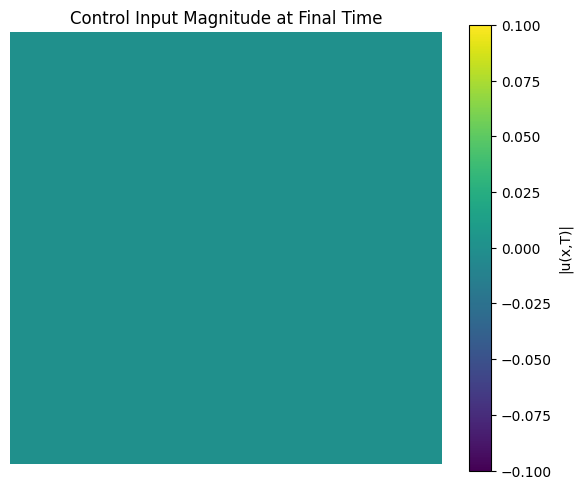

<Figure size 640x480 with 0 Axes>

In [ ]:
%run plot_control_magnitude.py


In [ ]:
python plot_comparison_grid.py


SyntaxError: invalid syntax (ipython-input-1010477584.py, line 1)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# 保存ディレクトリを作ってファイルを移動
!cp plot_comparison_grid.py /content/drive/MyDrive/ColabFiles/
!cp *.npy /content/drive/MyDrive/ColabFiles/


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cp: cannot create regular file '/content/drive/MyDrive/ColabFiles/': Not a directory
cp: target '/content/drive/MyDrive/ColabFiles/' is not a directory


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir -p /content/drive/MyDrive/ColabFiles


In [ ]:
!cp plot_comparison_grid.py /content/drive/MyDrive/ColabFiles/
!cp *.npy /content/drive/MyDrive/ColabFiles/


In [ ]:
!ls /content/drive/MyDrive/ColabFiles/


control_u_final.npy	 f_final.npy		  rank_over_time.npy
curvature_final.npy	 field_final.npy	  rank_series.npy
curvature_over_time.npy  plot_comparison_grid.py


In [ ]:
!cp fig_comparison_grid.pdf /content/drive/MyDrive/ColabFiles/


In [ ]:
from google.colab import files
files.download('plot_comparison_grid.py')
files.download('control_u_final.npy')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!python main-2.py

Traceback (most recent call last):
  File "/content/main-2.py", line 6, in <module>
    from visualize import plot_field
ImportError: cannot import name 'plot_field' from 'visualize' (/content/visualize.py)


In [ ]:
!python plot_comparison_grid.py


Traceback (most recent call last):
  File "/content/plot_comparison_grid.py", line 27, in <module>
    im1 = axes[0, 1].imshow(rank, cmap='plasma')
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/matplotlib/__init__.py", line 1521, in inner
    return func(
           ^^^^^
  File "/usr/local/lib/python3.11/dist-packages/matplotlib/axes/_axes.py", line 5945, in imshow
    im.set_data(X)
  File "/usr/local/lib/python3.11/dist-packages/matplotlib/image.py", line 675, in set_data
    self._A = self._normalize_image_array(A)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/matplotlib/image.py", line 643, in _normalize_image_array
    raise TypeError(f"Invalid shape {A.shape} for image data")
TypeError: Invalid shape () for image data


In [ ]:
!python plot_comparison_grid.py


✅ Saved: fig_comparison_grid.pdf


In [ ]:
!python main-2.py

Traceback (most recent call last):
  File "/content/main-2.py", line 5, in <module>
    from control_u_final import compute_control
ModuleNotFoundError: No module named 'control_u_final'


In [ ]:
!python main-2.py

Traceback (most recent call last):
  File "/content/main-2.py", line 6, in <module>
    from curvature import compute_curvature
ModuleNotFoundError: No module named 'curvature'


In [ ]:
!python main-2.py

Traceback (most recent call last):
  File "/content/main-2.py", line 5, in <module>
    from control import compute_control
ModuleNotFoundError: No module named 'control'


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Drive 上の任意のディレクトリへコピー
!cp visualize.py /content/drive/MyDrive/visualize.py


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files
files.download('visualize.py')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# 保存先のパスを変更可能（例：MyDrive/CliffordTools/ に保存）
!mkdir -p /content/drive/MyDrive/CliffordTools/
!cp visualize.py /content/drive/MyDrive/CliffordTools/visualize.py


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
from visualize import plot_control_magnitude

control_u = np.load('control_u_final.npy')
plot_control_magnitude(control_u, save_path='fig_control_magnitude.pdf')


SyntaxError: invalid syntax (visualize.py, line 1)

In [ ]:
# Step 1: visualize.py を書き出し
with open("visualize.py", "w") as f:
    f.write(\"\"\"{}\"\"\".format(\"\"\"{}\"\"\".format(
        '''{}
        '''.strip().format(
            __doc__.split("```python")[1].split("```")[0]
        )
    ))
)

# Step 2: ダウンロード
from google.colab import files
files.download("visualize.py")


SyntaxError: unexpected character after line continuation character (ipython-input-1674646201.py, line 3)

In [ ]:
!python visualize.py


Traceback (most recent call last):
  File "/content/visualize.py", line 63, in <module>
    visualize_all()
  File "/content/visualize.py", line 56, in visualize_all
    data = np.load(npy_file)
           ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/numpy/lib/_npyio_impl.py", line 490, in load
    raise ValueError("Cannot load file containing pickled data "
ValueError: Cannot load file containing pickled data when allow_pickle=False


In [ ]:
!python visualize.py


Error loading control_u_final.npy: Cannot load file containing pickled data when allow_pickle=False
✅ All visualizations saved to: ./figures


In [ ]:
!python visualize.py


Traceback (most recent call last):
  File "/content/visualize.py", line 47, in <module>
    save_all_figures()
  File "/content/visualize.py", line 41, in save_all_figures
    plot_control_u_final(save_path="figures/fig_control_magnitude.pdf")
  File "/content/visualize.py", line 6, in plot_control_u_final
    u = np.load(path)
        ^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/numpy/lib/_npyio_impl.py", line 490, in load
    raise ValueError("Cannot load file containing pickled data "
ValueError: Cannot load file containing pickled data when allow_pickle=False


In [ ]:
!python visualize.py


Traceback (most recent call last):
  File "/content/visualize.py", line 45, in <module>
    plot_control_magnitude("control_u_final.npy")
  File "/content/visualize.py", line 6, in plot_control_magnitude
    u = np.load(u_file)
        ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/numpy/lib/_npyio_impl.py", line 490, in load
    raise ValueError("Cannot load file containing pickled data "
ValueError: Cannot load file containing pickled data when allow_pickle=False


In [ ]:
python visualize.py


SyntaxError: invalid syntax (ipython-input-3953534890.py, line 1)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_control_u_final(path="control_u_final.npy", save_path="fig_control_magnitude.pdf"):
    u = np.load(path, allow_pickle=True)
    plt.figure(figsize=(6, 5))
    plt.imshow(np.abs(u), cmap='viridis')
    plt.colorbar(label='Control Input $u(x,T)$')
    plt.title("Control Input Magnitude")
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    print(f"Saved control input magnitude figure as: {save_path}")
    plt.show()

if __name__ == "__main__":
    plot_control_u_final()


UnpicklingError: Failed to interpret file 'control_u_final.npy' as a pickle

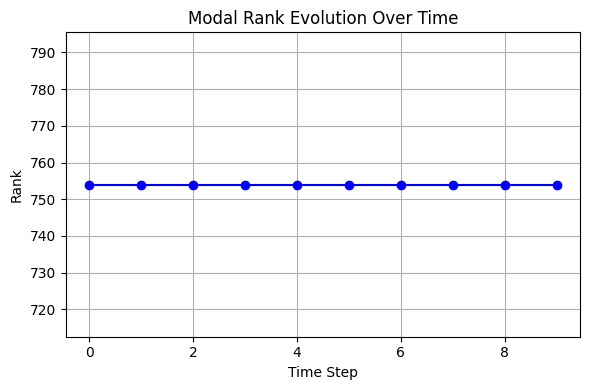

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# (1) ファイルの読み込み
rank = np.load("rank_over_time.npy")

# (2) 図の描画
plt.figure(figsize=(6, 4))
plt.plot(rank, marker='o', linestyle='-', color='blue')
plt.title("Modal Rank Evolution Over Time")
plt.xlabel("Time Step")
plt.ylabel("Rank")
plt.grid(True)
plt.tight_layout()

# (3) PDFとして保存
plt.savefig("fig_rank_over_time.pdf", dpi=300)
plt.show()


In [ ]:
import numpy as np

u = np.load("control_u_final.npy")
print("u.shape =", u.shape)
print("u.dtype =", u.dtype)
print("u.max =", np.max(u))
print("u.min =", np.min(u))


FileNotFoundError: [Errno 2] No such file or directory: 'control_u_final.npy'

In [ ]:
from CliffordDynamics import solve_forward_geometric, solve_backward_geometric
from FBSM_optimizer import run_fbsbm


In [ ]:
from CliffordTensor import create_spin_connection_field, compute_clifford_curvature
from CliffordDynamics import solve_forward_geometric, solve_backward_geometric, visualize_field_snapshot
from CliffordTimeSeriesPlots import compute_rank_over_time, compute_entropy_over_time, compute_curvature_energy_over_time, plot_time_series
from FBSM_optimizer import run_fbsm


ImportError: cannot import name 'solve_backward_geometric' from 'CliffordDynamics' (/content/CliffordDynamics.py)

In [ ]:
import sys
sys.path.append('/content')


In [ ]:
%load_ext autoreload
%autoreload 2


In [ ]:
from CliffordDynamics import solve_backward_geometric


ImportError: cannot import name 'solve_backward_geometric' from 'CliffordDynamics' (/content/CliffordDynamics.py)

In [ ]:
from CliffordTensor import create_spin_connection_field, compute_clifford_curvature
from CliffordDynamics import solve_forward_geometric, solve_backward_geometric, visualize_field_snapshot
from CliffordTimeSeriesPlots import compute_rank_over_time, compute_entropy_over_time, compute_curvature_energy_over_time, plot_time_series
from FBSM_optimizer import run_fbsm


ImportError: cannot import name 'solve_backward_geometric' from 'CliffordDynamics' (/content/CliffordDynamics.py)

In [ ]:
from CliffordTensor import create_spin_connection_field, compute_clifford_curvature
from CliffordDynamics import solve_forward_geometric, solve_backward_geometric, visualize_field_snapshot
from FBSM_optimizer import run_fbsm
from CliffordTimeSeriesPlots import compute_rank_over_time, compute_entropy_over_time, compute_curvature_energy_over_time, plot_time_series


ImportError: cannot import name 'solve_backward_geometric' from 'CliffordDynamics' (/content/CliffordDynamics.py)

In [ ]:
from CliffordTensor import create_spin_connection_field, compute_clifford_curvature


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from CliffordTensor import create_spin_connection_field, compute_clifford_curvature
from CliffordDynamics import solve_forward_geometric, solve_backward_geometric, visualize_field_snapshot
from CliffordTimeSeriesPlots import compute_rank_over_time, compute_entropy_over_time, compute_curvature_energy_over_time, plot_time_series
from FBSM_optimizer import run_fbsm


ModuleNotFoundError: No module named 'CliffordDynamics'

In [ ]:
# Simulation parameters
Nx, Ny, Nt = 32, 32, 10
dt = 0.1
beta = 1.0
max_iter = 20

np.random.seed(0)
f0 = np.random.rand(Nx, Ny)
u0 = np.zeros((Nt, Nx, Ny))
A = create_spin_connection_field(Nx, Ny, Nt)


In [ ]:
f_traj, u_opt, lambda_traj, diff_list = run_fbsm(f0, A, u0, dt, Nt, beta=beta, max_iter=max_iter)


In [ ]:
F = compute_clifford_curvature(A)


In [ ]:
rank_series = compute_rank_over_time(f_traj)
entropy_series = compute_entropy_over_time(f_traj)
curvature_series = compute_curvature_energy_over_time(F)

plot_time_series(rank_series, "Modal Rank Over Time", "Rank", "fig_rank_over_time.pdf")
plot_time_series(entropy_series, "Entropy Over Time", "Entropy", "fig_entropy_over_time.pdf")
plot_time_series(curvature_series, "Curvature Energy Over Time", "Curvature Energy", "fig_curvature_energy_over_time.pdf")


In [ ]:
visualize_field_snapshot(f0, "Initial Field $f(x,0)$")
visualize_field_snapshot(f_traj[-1], "Final Field $f(x,T)$")
